# The problem

A set of antibody sequences, also known as constructs, have been generated from a starting sequence, also known as a parent construct, (antibody_001) to optimize thermostability (increase in melting temperature, also referred to as Tm [°C]]). These constructs have only one mutation relative to the parent construct. These constructs have also been measured in the protein quantification assay (concentration [ng/uL]). Some constructs have been measured multiple times in one or both assays. Three datasets contain all the necessary data for this analysis: a construct metadata dataset (.csv), a protein quantification dataset, and a thermostability dataset (both zipped parquet files). Please write a script and generate figures to answer the following questions:  

● Which constructs have most improved thermostability relative to the parent construct?  
● What is the relationship (if any) between optimization of thermostability and protein
concentration?  
● Are there mutations in the dataset that directly affect thermostability? Protein
concentration?  
● What is the variability of replicate measurements in thermostability? Protein
concentration?

# Setup

In [4]:
# mount google colab to my drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# import packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pyarrow.parquet as pq
import plotnine as p9
from plotnine import *
from scipy import stats

In [6]:
# set current working directory
WDIR = '/content/gdrive/MyDrive/BigHat_techscreen_MI/'

# directory for output files
# OUTDIR = WDIR + "output/"

In [7]:
# verify correct directory is visible
os.listdir(WDIR)

['thermostability.parquet.gzip',
 'protein_quant.parquet.gzip',
 'construct_meta.csv',
 'BigHat Take Home Tech Screen.pdf',
 'output',
 'BigHat_techscreen_MI.ipynb']

# Data Upload

In [8]:
# upload csv of constructs
df = pd.read_csv(WDIR + "construct_meta.csv", index_col=0)
df.head()

,construct_name,construct_sequence
0,antibody_0001,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...
1,antibody_0002,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKELASTIIGY...
2,antibody_0003,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...
3,antibody_0004,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...
4,antibody_0005,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...


In [9]:
# upload protein quant data
pq_quant = pq.read_table(WDIR + "protein_quant.parquet.gzip")

In [10]:
# convert parquet file to dataframe
df_quant = pq_quant.to_pandas()
df_quant.head()

,construct_name,protein_aliquot_name,conc_ng_ul,experiment_date
0,antibody_0001,antibody_0001-G,100.34,2023-11-15
1,antibody_0001,antibody_0001-B,123.47,2023-11-06
2,antibody_0001,antibody_0001-E,97.10,2023-11-13
3,antibody_0001,antibody_0001-D,106.45,2023-11-09
4,antibody_0001,antibody_0001-J,113.61,2023-11-17


In [11]:
# upload thermostability data
pq_thermo = pq.read_table(WDIR + "thermostability.parquet.gzip")

In [12]:
# convert parquet to dataframe
df_thermo = pq_thermo.to_pandas()
df_thermo.head()

,construct_name,protein_aliquot_name,uncle_tm_cels,experiment_date
0,antibody_0001,antibody_0001-H,56.63,2023-11-15
1,antibody_0001,antibody_0001-B,61.03,2023-11-06
2,antibody_0001,antibody_0001-F,53.99,2023-11-13
3,antibody_0001,antibody_0001-D,57.18,2023-11-09
4,antibody_0001,antibody_0001-J,54.99,2023-11-17


# Data exploration

In [13]:
# which observations do we have for which constructs?
df_thermo.construct_name.value_counts()

antibody_0001    18
antibody_0195     7
antibody_0127     6
antibody_0026     6
antibody_0358     6
                 ..
antibody_0396     1
antibody_0295     1
antibody_0237     1
antibody_0292     1
antibody_0144     1
Name: construct_name, Length: 374, dtype: int64

In [14]:
df_quant.construct_name.value_counts()

antibody_0001    18
antibody_0106     6
antibody_0083     5
antibody_0080     5
antibody_0282     5
                 ..
antibody_0042     1
antibody_0102     1
antibody_0402     1
antibody_0367     1
antibody_0060     1
Name: construct_name, Length: 340, dtype: int64

In [15]:
# summarize values per antibody
pd.set_option("display.max_rows", 10)

df_quant.groupby("construct_name")["conc_ng_ul"].agg(["mean","std","min","max","median","count"])

,mean,std,min,max,median,count
construct_name,,,,,,
antibody_0001,129.216111,55.753415,97.10,341.57,114.785,18
antibody_0003,103.453333,28.639145,70.43,121.48,118.450,3
antibody_0004,105.943333,21.418883,91.05,130.49,96.290,3
antibody_0005,90.450000,11.723830,82.16,98.74,90.450,2
antibody_0006,128.745000,17.557461,116.33,141.16,128.745,2
...,...,...,...,...,...,...
antibody_0403,99.660000,16.574583,87.94,111.38,99.660,2
antibody_0404,86.450000,12.713780,77.46,95.44,86.450,2
antibody_0406,91.615000,10.726810,84.03,99.20,91.615,2


In [16]:
df_thermo_stats = df_thermo.groupby("construct_name")["uncle_tm_cels"].agg(["mean","std","min","max","median","count"])

## Which constructs have most improved thermostability relative to the parental?

In [17]:
# designate parental name and TM
PARENTAL = "antibody_0001"
# extract melting point of parental from data
PARENTAL_TM = df_thermo_stats.filter(like=PARENTAL, axis=0)["mean"].tolist()[0]
PARENTAL_TM

57.13444444444445

In [18]:
# Find constructs with higher mean melting temperature compared to parental 0001

# filter dataframe of TM means to those greater than parental mean,
# as well as the parental
# sorted from largest Tm to smallest

df_thermo_improved = df_thermo_stats[(df_thermo_stats["mean"] > PARENTAL_TM) | (df_thermo_stats.index == PARENTAL)]
df_thermo_improved = df_thermo_improved.sort_values(by="mean", ascending=False)

# convert construct name to categorical to preserve order in plots
df_thermo_improved.index = pd.Categorical(df_thermo_improved.index, categories=pd.unique(df_thermo_improved.index))
df_thermo_improved


,mean,std,min,max,median,count
antibody_0035,70.970000,NaN,70.97,70.97,70.970,1
antibody_0043,70.420000,NaN,70.42,70.42,70.420,1
antibody_0122,66.460000,NaN,66.46,66.46,66.460,1
antibody_0321,66.310000,NaN,66.31,66.31,66.310,1
antibody_0276,65.845000,3.245620,63.55,68.14,65.845,2
...,...,...,...,...,...,...
antibody_0389,57.390000,3.096659,53.96,59.98,58.230,3
antibody_0357,57.366667,3.336500,54.27,60.90,56.930,3
antibody_0215,57.280000,NaN,57.28,57.28,57.280,1
antibody_0090,57.155000,4.103499,52.69,61.33,57.300,4


In [19]:
# write out to csv
# df_thermo_improved.to_csv(path_or_buf=OUTDIR + "thermostability_improved_means.csv")

In [20]:
# based on the mean values above, subset the original thermostability dataset
# for all construct names that match
df_thermo_improved_all = df_thermo[df_thermo.construct_name.isin(df_thermo_improved.index)]
# df_thermo_improved_all.to_csv(OUTDIR + "thermostability_improved.csv")

In [21]:
df_thermo_improved_all

,construct_name,protein_aliquot_name,uncle_tm_cels,experiment_date
0,antibody_0001,antibody_0001-H,56.63,2023-11-15
1,antibody_0001,antibody_0001-B,61.03,2023-11-06
2,antibody_0001,antibody_0001-F,53.99,2023-11-13
3,antibody_0001,antibody_0001-D,57.18,2023-11-09
4,antibody_0001,antibody_0001-J,54.99,2023-11-17
...,...,...,...,...
760,antibody_0344,antibody_0344-A,57.32,2023-11-06
762,antibody_0081,antibody_0081-D,58.12,2023-11-28
768,antibody_0251,antibody_0251-B,63.78,2023-11-21
769,antibody_0361,antibody_0361-B,54.26,2023-11-13


In [22]:
# add parental identity for filling plot bar
df_thermo_improved["is_parental"] = df_thermo_improved.index == PARENTAL
df_thermo_improved

,mean,std,min,max,median,count,is_parental
antibody_0035,70.970000,NaN,70.97,70.97,70.970,1,False
antibody_0043,70.420000,NaN,70.42,70.42,70.420,1,False
antibody_0122,66.460000,NaN,66.46,66.46,66.460,1,False
antibody_0321,66.310000,NaN,66.31,66.31,66.310,1,False
antibody_0276,65.845000,3.245620,63.55,68.14,65.845,2,False
...,...,...,...,...,...,...,...
antibody_0389,57.390000,3.096659,53.96,59.98,58.230,3,False
antibody_0357,57.366667,3.336500,54.27,60.90,56.930,3,False
antibody_0215,57.280000,NaN,57.28,57.28,57.280,1,False
antibody_0090,57.155000,4.103499,52.69,61.33,57.300,4,False


/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 69 rows containing missing values.


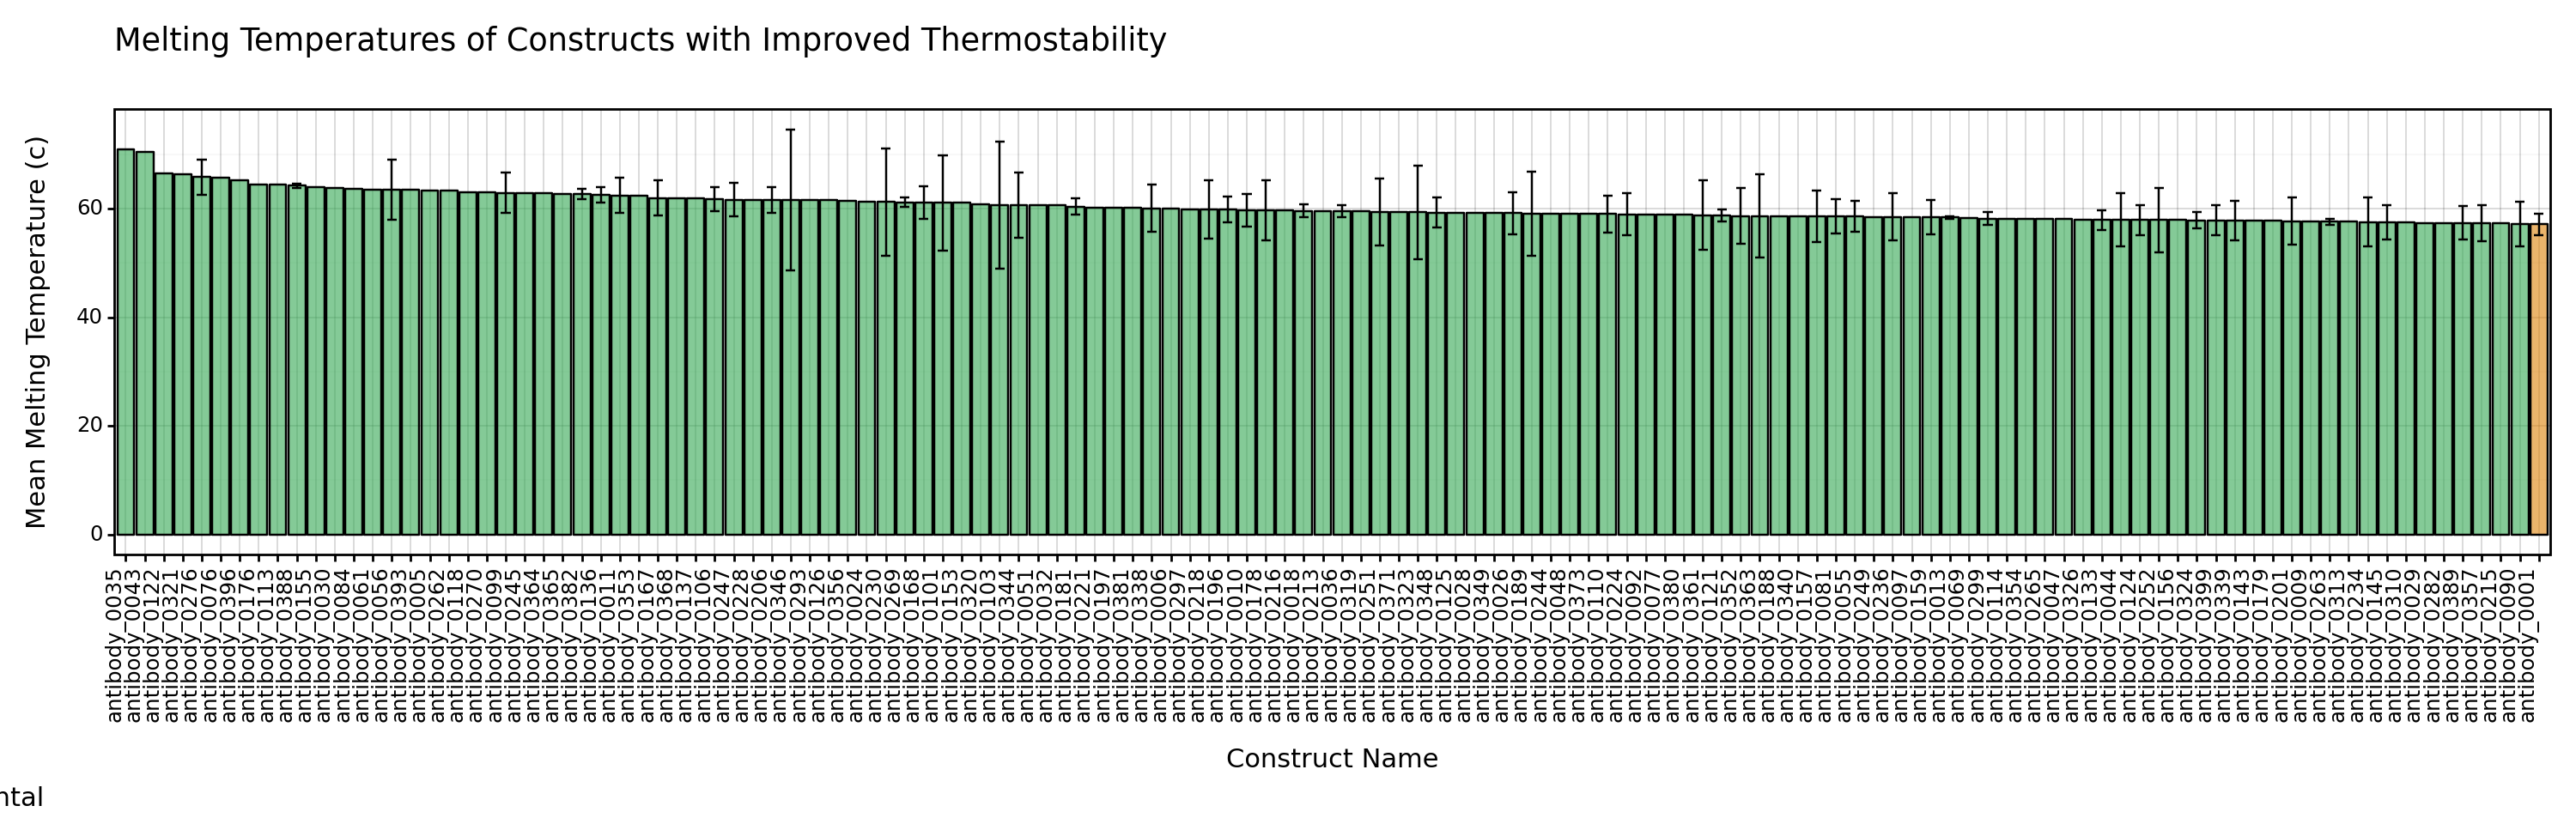

<Figure Size: (1500 x 480)>

In [23]:
# plot barplot of improved thermostability
# with error bars calculated via mean +/- standard deviation
p9.options.figure_size = (15, 4.8)
plt_thermo = (ggplot(df_thermo_improved, mapping=aes(x = "df_thermo_improved.index", y = "mean")) +
 geom_bar(stat="identity", color="black", alpha=0.6, mapping=aes(fill = "is_parental")) +
 theme_linedraw() +
 theme(axis_text_x=element_text(rotation=90, hjust=1),
       legend_position="None") +
 geom_errorbar(mapping=aes(x = "df_thermo_improved.index", ymin="mean-std", ymax="mean+std"))+
 xlab("Construct Name") +
 ylab("Mean Melting Temperature (c)") +
 labs(title = "Melting Temperatures of Constructs with Improved Thermostability") +
              scale_fill_manual(values = ["#32a852","#de8209"])
 )
plt_thermo

The constructs listed above have the most improved thermostability relative to the parental.

# What is the relationship (if any) between optimization of thermostability and protein concentration?

In [24]:
# get summary statistics of protein quant data
df_quant_stats = df_quant.groupby("construct_name")["conc_ng_ul"].agg(["mean","std","min","max","median","count"])
df_quant_stats

,mean,std,min,max,median,count
construct_name,,,,,,
antibody_0001,129.216111,55.753415,97.10,341.57,114.785,18
antibody_0003,103.453333,28.639145,70.43,121.48,118.450,3
antibody_0004,105.943333,21.418883,91.05,130.49,96.290,3
antibody_0005,90.450000,11.723830,82.16,98.74,90.450,2
antibody_0006,128.745000,17.557461,116.33,141.16,128.745,2
...,...,...,...,...,...,...
antibody_0403,99.660000,16.574583,87.94,111.38,99.660,2
antibody_0404,86.450000,12.713780,77.46,95.44,86.450,2
antibody_0406,91.615000,10.726810,84.03,99.20,91.615,2


In [25]:
# merge quant and thermostability data via construct name

df_stats = df_quant_stats.merge(df_thermo_stats,
                                on = "construct_name",
                                how = "left",
                                suffixes = ("_conc","_tm"))

# designate optimized thermostability or not
df_stats["is_tm_improved"] = df_stats.index.isin(df_thermo_improved.index.remove_categories(PARENTAL))
df_stats

,mean_conc,std_conc,min_conc,max_conc,median_conc,count_conc,mean_tm,std_tm,min_tm,max_tm,median_tm,count_tm,is_tm_improved
construct_name,,,,,,,,,,,,,
antibody_0001,129.216111,55.753415,97.10,341.57,114.785,18,57.134444,1.991618,53.99,61.03,56.905,18.0,False
antibody_0003,103.453333,28.639145,70.43,121.48,118.450,3,57.063333,10.665535,44.75,63.42,63.020,3.0,False
antibody_0004,105.943333,21.418883,91.05,130.49,96.290,3,50.710000,NaN,50.71,50.71,50.710,1.0,False
antibody_0005,90.450000,11.723830,82.16,98.74,90.450,2,63.440000,NaN,63.44,63.44,63.440,1.0,True
antibody_0006,128.745000,17.557461,116.33,141.16,128.745,2,60.040000,NaN,60.04,60.04,60.040,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
antibody_0403,99.660000,16.574583,87.94,111.38,99.660,2,52.576667,4.490215,47.70,56.54,53.490,3.0,False
antibody_0404,86.450000,12.713780,77.46,95.44,86.450,2,53.520000,2.495666,51.11,56.62,52.420,5.0,False
antibody_0406,91.615000,10.726810,84.03,99.20,91.615,2,NaN,NaN,NaN,NaN,NaN,NaN,False


In [26]:
df_stats[['mean_conc',
         'std_conc',
         'median_conc',
         'mean_tm',
         'std_tm',
         'median_tm',
         'is_tm_improved']].corr(method = "pearson",
                                numeric_only=False).style.background_gradient(cmap='coolwarm')

,mean_conc,std_conc,median_conc,mean_tm,std_tm,median_tm,is_tm_improved
mean_conc,1.000000,0.720507,0.961315,-0.078211,-0.090373,-0.080966,-0.018071
std_conc,0.720507,1.000000,0.558277,-0.047019,-0.085651,-0.040102,-0.071177
median_conc,0.961315,0.558277,1.000000,-0.078909,-0.091276,-0.082819,-0.012460
mean_tm,-0.078211,-0.047019,-0.078909,1.000000,0.105080,0.985714,0.775237
std_tm,-0.090373,-0.085651,-0.091276,0.105080,1.000000,0.115502,-0.000283
median_tm,-0.080966,-0.040102,-0.082819,0.985714,0.115502,1.000000,0.756626
is_tm_improved,-0.018071,-0.071177,-0.012460,0.775237,-0.000283,0.756626,1.000000


In [27]:
df_stats[['mean_conc',
         'std_conc',
         'median_conc',
         'mean_tm',
         'std_tm',
         'median_tm',
         'is_tm_improved']].corr(method = "spearman",
                                numeric_only=False).style.background_gradient(cmap='coolwarm')

,mean_conc,std_conc,median_conc,mean_tm,std_tm,median_tm,is_tm_improved
mean_conc,1.000000,0.268665,0.950753,-0.068328,-0.059971,-0.081991,-0.030420
std_conc,0.268665,1.000000,0.149008,-0.055345,-0.020848,-0.039158,-0.018500
median_conc,0.950753,0.149008,1.000000,-0.088697,-0.042910,-0.101864,-0.035668
mean_tm,-0.068328,-0.055345,-0.088697,1.000000,0.099941,0.980983,0.828730
std_tm,-0.059971,-0.020848,-0.042910,0.099941,1.000000,0.094074,-0.023604
median_tm,-0.081991,-0.039158,-0.101864,0.980983,0.094074,1.000000,0.798972
is_tm_improved,-0.030420,-0.018500,-0.035668,0.828730,-0.023604,0.798972,1.000000


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


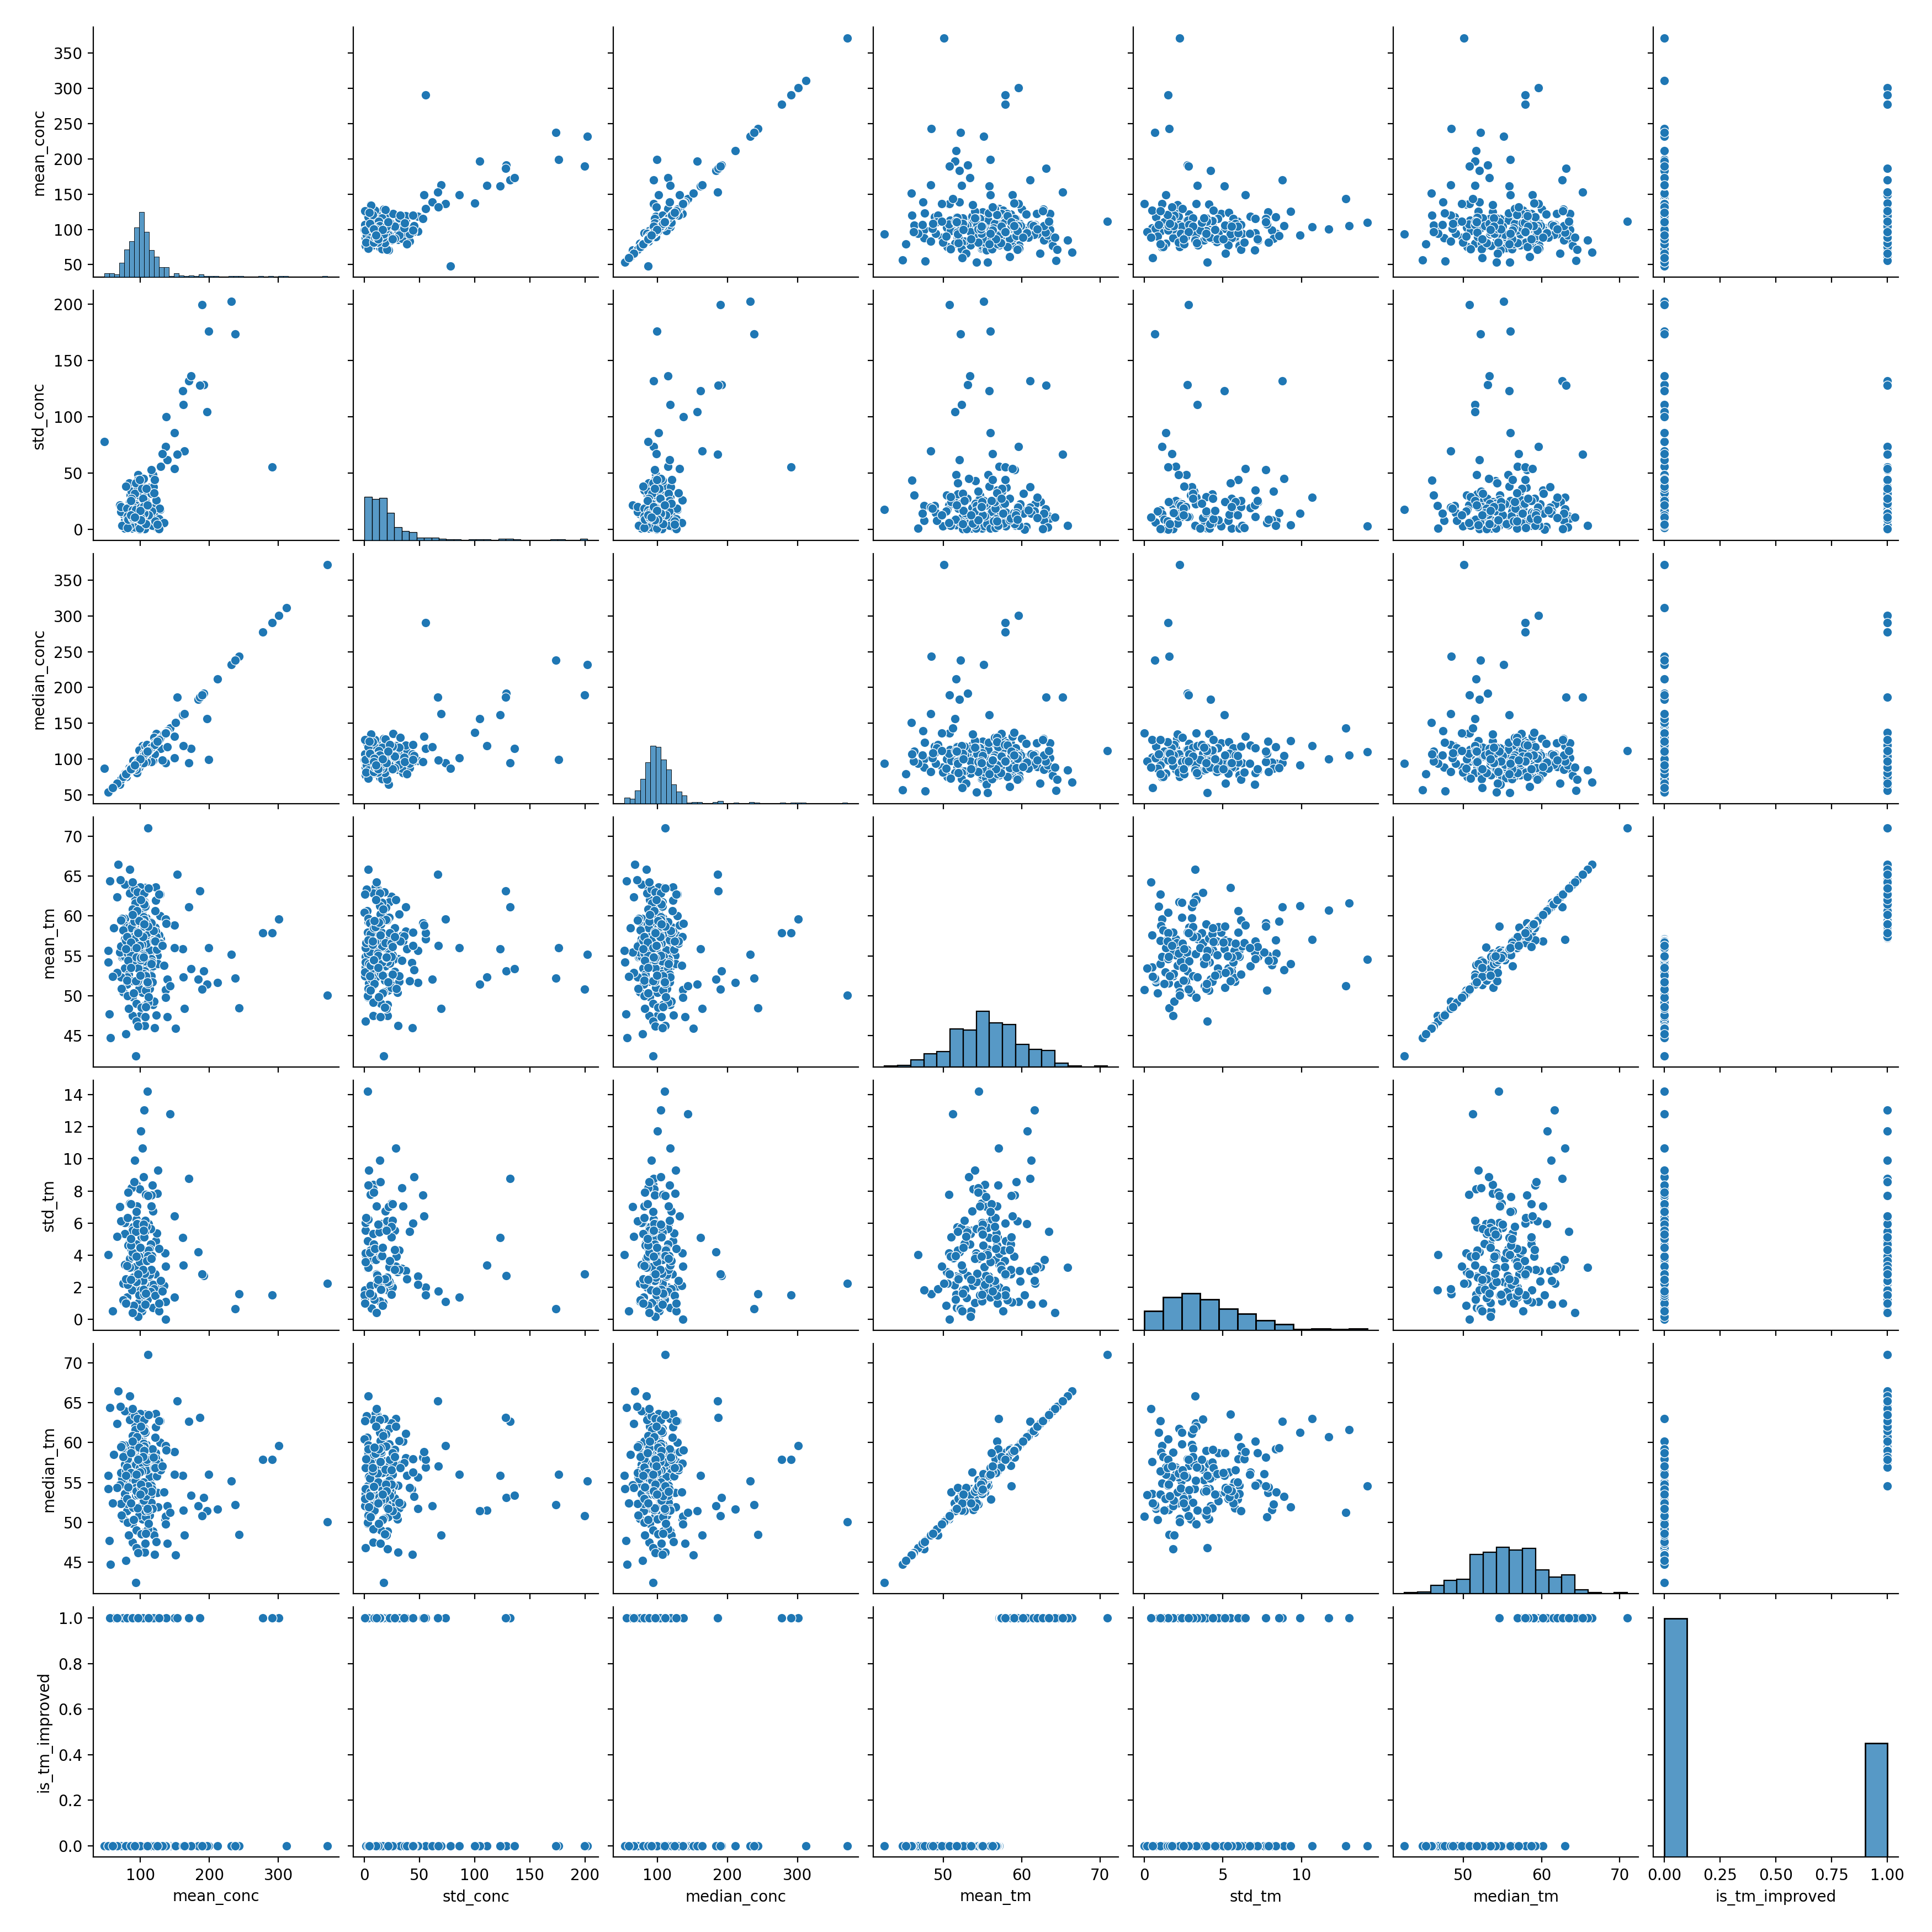

In [28]:
sns.pairplot(df_stats[['mean_conc',
         'std_conc',
         'median_conc',
         'mean_tm',
         'std_tm',
         'median_tm',
         'is_tm_improved']])

In [29]:
df_stats

,mean_conc,std_conc,min_conc,max_conc,median_conc,count_conc,mean_tm,std_tm,min_tm,max_tm,median_tm,count_tm,is_tm_improved
construct_name,,,,,,,,,,,,,
antibody_0001,129.216111,55.753415,97.10,341.57,114.785,18,57.134444,1.991618,53.99,61.03,56.905,18.0,False
antibody_0003,103.453333,28.639145,70.43,121.48,118.450,3,57.063333,10.665535,44.75,63.42,63.020,3.0,False
antibody_0004,105.943333,21.418883,91.05,130.49,96.290,3,50.710000,NaN,50.71,50.71,50.710,1.0,False
antibody_0005,90.450000,11.723830,82.16,98.74,90.450,2,63.440000,NaN,63.44,63.44,63.440,1.0,True
antibody_0006,128.745000,17.557461,116.33,141.16,128.745,2,60.040000,NaN,60.04,60.04,60.040,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
antibody_0403,99.660000,16.574583,87.94,111.38,99.660,2,52.576667,4.490215,47.70,56.54,53.490,3.0,False
antibody_0404,86.450000,12.713780,77.46,95.44,86.450,2,53.520000,2.495666,51.11,56.62,52.420,5.0,False
antibody_0406,91.615000,10.726810,84.03,99.20,91.615,2,NaN,NaN,NaN,NaN,NaN,NaN,False


/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


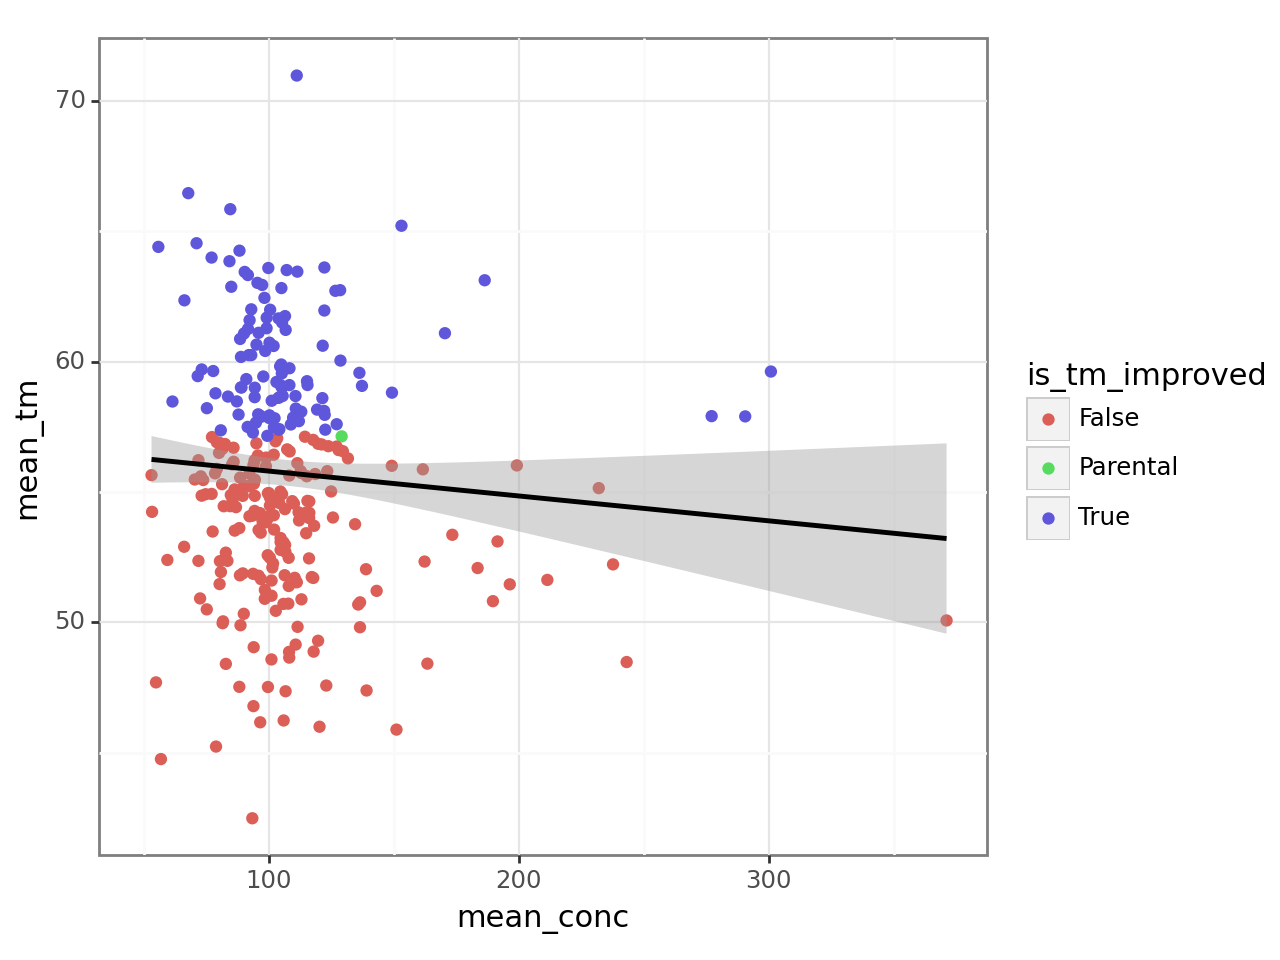

<Figure Size: (640 x 480)>

In [30]:
# copy dataframe for plot below: replace parental is_tm_improved False with Parental designation
df_stats_plt = df_stats.copy()

# visualize TM vs conc to spot any clear linear correlation

df_stats_plt["is_tm_improved"] = df_stats_plt["is_tm_improved"].replace({True: 'True', False: 'False'})
df_stats_plt.loc[PARENTAL,"is_tm_improved"] = "Parental"
p9.options.figure_size = (6.4, 4.8)
(ggplot(df_stats_plt, mapping=aes(x = "mean_conc", y = "mean_tm"))+
 geom_point(aes(color = "is_tm_improved")) +
 geom_smooth(method="lm") +
 theme_bw())

There is a slight negative correlation between the mean and median melting temperature and the mean and median concentration of protein (Pearson correlation coefficient =~ -0.08). Optimization of thermostability vs protein concentration could be better modeled with a logistic regression. The output variable (is optimized/is not optimized) is categorical, and there is no strong apparent linear relationship between raw TM values and protein concentration.

<Axes: xlabel='mean_conc', ylabel='is_tm_improved'>

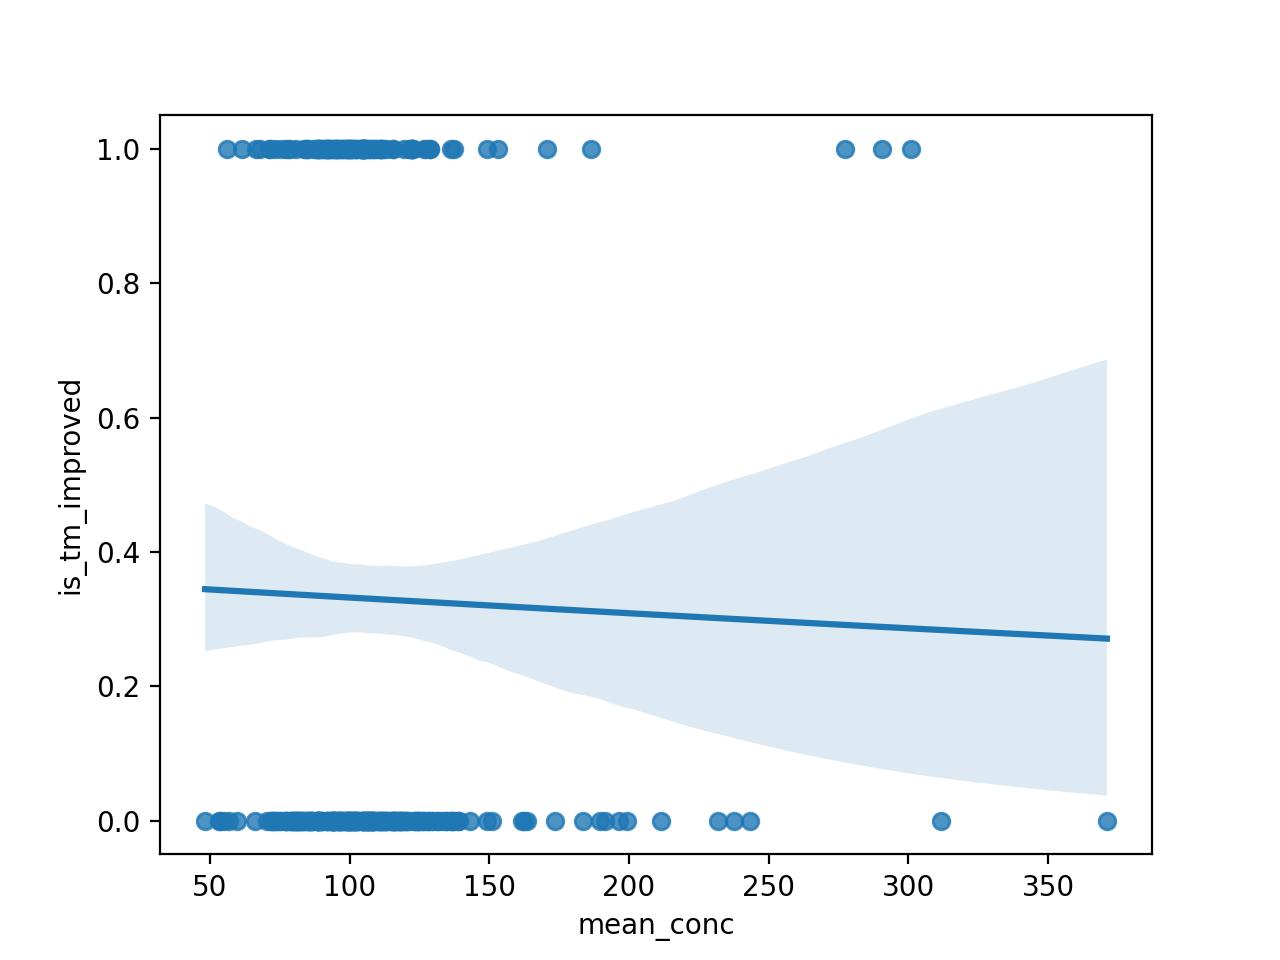

In [31]:
# explore a logistic relationship between concentration and TM improvement
sns.regplot(x=df_stats['mean_conc'],y=df_stats['is_tm_improved'],data=df_stats, logistic=True)

In [32]:
pd.crosstab(df_stats.mean_conc,df_stats.is_tm_improved)

is_tm_improved,False,True
mean_conc,,
48.255,1,0
53.190,1,0
53.420,1,0
54.990,1,0
55.930,0,1
...,...,...
277.160,0,1
290.585,0,1
300.860,0,1


In [33]:
df_stats["is_tm_improved"] = df_stats.is_tm_improved.astype(int)

mod_logit_conc = smf.logit(formula='is_tm_improved ~ mean_conc', data=df_stats).fit()

Optimization terminated successfully.
         Current function value: 0.634246
         Iterations 5


In [34]:
mod_logit_conc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         is_tm_improved   No. Observations:                  333
Model:                          Logit   Df Residuals:                      331
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:               0.0002614
Time:                        19:08:12   Log-Likelihood:                -211.20
converged:                       True   LL-Null:                       -211.26
Covariance Type:            nonrobust   LLR p-value:                    0.7396
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5910      0.369     -1.600      0.110      -1.315       0.133
mean_conc     -0.0011      0.003     -0.329      0.742      -0.007       0.005
==============================================================================
"""

In [35]:
# log odds: coefficient of mean_conc
# shows equal probability of success (TM improvement) and failure
np.exp(-0.0011)

0.9989006047782276

There is not a strong relationship between optimization of thermostability and protein concentration.

# Are there mutations in the dataset that directly affect thermostability? Protein concentration?

In [36]:
# merge all sequences, statistics on concentration, and thermostability
# into one dataframe
df_all_stats = df.merge(df_stats, on = "construct_name", how = "left")
df_all_stats


,construct_name,construct_sequence,mean_conc,std_conc,min_conc,max_conc,median_conc,count_conc,mean_tm,std_tm,min_tm,max_tm,median_tm,count_tm,is_tm_improved
0,antibody_0001,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...,129.216111,55.753415,97.10,341.57,114.785,18.0,57.134444,1.991618,53.99,61.03,56.905,18.0,0.0
1,antibody_0002,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKELASTIIGY...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,antibody_0003,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...,103.453333,28.639145,70.43,121.48,118.450,3.0,57.063333,10.665535,44.75,63.42,63.020,3.0,0.0
3,antibody_0004,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...,105.943333,21.418883,91.05,130.49,96.290,3.0,50.710000,NaN,50.71,50.71,50.710,1.0,0.0
4,antibody_0005,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...,90.450000,11.723830,82.16,98.74,90.450,2.0,63.440000,NaN,63.44,63.44,63.440,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,antibody_0404,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIDSTIIGY...,86.450000,12.713780,77.46,95.44,86.450,2.0,53.520000,2.495666,51.11,56.62,52.420,5.0,0.0
404,antibody_0405,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,antibody_0406,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...,91.615000,10.726810,84.03,99.20,91.615,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
406,antibody_0407,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGY...,110.450000,21.679894,95.12,125.78,110.450,2.0,51.710000,NaN,51.71,51.71,51.710,1.0,0.0


In [37]:
# Explore how to characterize mutations within the sequences

pd.set_option("display.max_rows", 10)
L = len(df_all_stats.construct_sequence[0]) + 10
pd.options.display.max_colwidth = L

df_all_stats.construct_sequence

0      MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH
1      MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKELASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH
2      MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVFH
3      MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSEMVLH
4      MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKGQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH
                                                       ...                                                 
403    MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIDSTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH
404    MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMTKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH
405    MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQNSETVLH
406    MDDNEDLKFITDEAFCYHYDW

In [38]:
df_all_stats[df_all_stats["construct_name"] == PARENTAL]

,construct_name,construct_sequence,mean_conc,std_conc,min_conc,max_conc,median_conc,count_conc,mean_tm,std_tm,min_tm,max_tm,median_tm,count_tm,is_tm_improved
0,antibody_0001,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH,129.216111,55.753415,97.1,341.57,114.785,18.0,57.134444,1.991618,53.99,61.03,56.905,18.0,0.0


In [39]:
# designate parental sequence
PARENTAL_SEQ = df_all_stats[df_all_stats["construct_name"] == PARENTAL].construct_sequence[0]
PARENTAL_SEQ

'MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH'

In [40]:
# isolate all experimental constructs
P_LEN = len(PARENTAL_SEQ)
df_constructs_stats = df_all_stats[df_all_stats["construct_name"] != PARENTAL]
construct_names = df_constructs_stats.construct_name.tolist()
construct_seqs = df_constructs_stats.construct_sequence.tolist()

# initiate empty lists to store values with mutation information

MUTATION_TYPES = [] # either AA change, insertion, or deletion
MUT_INDEX = [] # location where mutation occurs
WT_RESIDUE = [] # parental amino acid at the mutation position
MUT_RESIDUE = [] # mutated amino acid

# loop through all construct sequences, identify mutation type and details
for TEST_SEQ in construct_seqs:
  if len(TEST_SEQ) == P_LEN: # sequences with the same length as parental
    MUTATION_TYPE = "AA_change"
    for i in range(P_LEN):
      if PARENTAL_SEQ[i] != TEST_SEQ[i]:
        MUTATION_INDEX = i
        WT = PARENTAL_SEQ[MUTATION_INDEX] # wild type amino acid at that position
        MUTATION = TEST_SEQ[MUTATION_INDEX] # mutated aa at that position
  elif len(TEST_SEQ) > P_LEN: # sequences longer than parental
    MUTATION_TYPE = "Insertion"
    for i in range(P_LEN):
      if PARENTAL_SEQ[i] != TEST_SEQ[i]:
        MUTATION_INDEX = i # identify where insertion occurs
        WT = PARENTAL_SEQ[MUTATION_INDEX] # wild type amino acid at that position
        MUTATION = TEST_SEQ[MUTATION_INDEX] # mutated aa at that position
        break
  elif len(TEST_SEQ) < P_LEN: # sequences shorter than parental
    MUTATION_TYPE = "Deletion"
    for i in range(len(TEST_SEQ)):
      if PARENTAL_SEQ[i] != TEST_SEQ[i]:
        MUTATION_INDEX = i # identify where insertion occurs
        WT = PARENTAL_SEQ[MUTATION_INDEX] # wild type amino acid at that position
        MUTATION = TEST_SEQ[MUTATION_INDEX] # mutated aa at that position
        break
  MUTATION_TYPES.append(MUTATION_TYPE)
  MUT_INDEX.append(MUTATION_INDEX)
  WT_RESIDUE.append(WT)
  MUT_RESIDUE.append(MUTATION)

In [41]:
# combine mutation summaries into dataframe
len(MUTATION_TYPES)
len(MUT_RESIDUE)

df_mutations = pd.DataFrame(zip(construct_names, construct_seqs, MUTATION_TYPES, MUT_INDEX, WT_RESIDUE, MUT_RESIDUE),
             columns = ["construct_name","construct_sequence","mutation_type","mutation_index","wt_aa","mut_aa"])

df_mutations

,construct_name,construct_sequence,mutation_type,mutation_index,wt_aa,mut_aa
0,antibody_0002,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKELASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH,AA_change,38,I,L
1,antibody_0003,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVFH,AA_change,98,L,F
2,antibody_0004,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSEMVLH,AA_change,96,T,M
3,antibody_0005,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKGQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH,AA_change,67,K,G
4,antibody_0006,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMHKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH,AA_change,65,M,H
...,...,...,...,...,...,...
402,antibody_0404,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIDSTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH,AA_change,39,A,D
403,antibody_0405,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMTKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETVLH,AA_change,65,M,T
404,antibody_0406,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQNSETVLH,AA_change,93,C,N
405,antibody_0407,MDDNEDLKFITDEAFCYHYDWMQQGFQDASPGMWGDKEIASTIIGYVQEESEQKAEWHQSILVRMMKKQFVGFYAKNKTQMAYIIFEDDQGMQCSETQLH,AA_change,97,V,Q


In [42]:
# merge mutation summary dataframe with statistics of constructs

df_mutations_stats = df_mutations.merge(df_constructs_stats,
                                        how = "left",
                                        left_on = ["construct_name","construct_sequence"],
                                        right_on=["construct_name","construct_sequence"])
# change data types of aa mutation/types and tm improvement categories
df_mutations_stats = df_mutations_stats.astype({"mutation_type" : "category",
                           "wt_aa" : "category",
                           "mut_aa" : "category",
                            "is_tm_improved" : "category"})

df_mutations_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 406
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   construct_name      407 non-null    object  
 1   construct_sequence  407 non-null    object  
 2   mutation_type       407 non-null    category
 3   mutation_index      407 non-null    int64   
 4   wt_aa               407 non-null    category
 5   mut_aa              407 non-null    category
 6   mean_conc           332 non-null    float64 
 7   std_conc            204 non-null    float64 
 8   min_conc            332 non-null    float64 
 9   max_conc            332 non-null    float64 
 10  median_conc         332 non-null    float64 
 11  count_conc          339 non-null    float64 
 12  mean_tm             309 non-null    float64 
 13  std_tm              175 non-null    float64 
 14  min_tm              309 non-null    float64 
 15  max_tm              309 non-null    floa

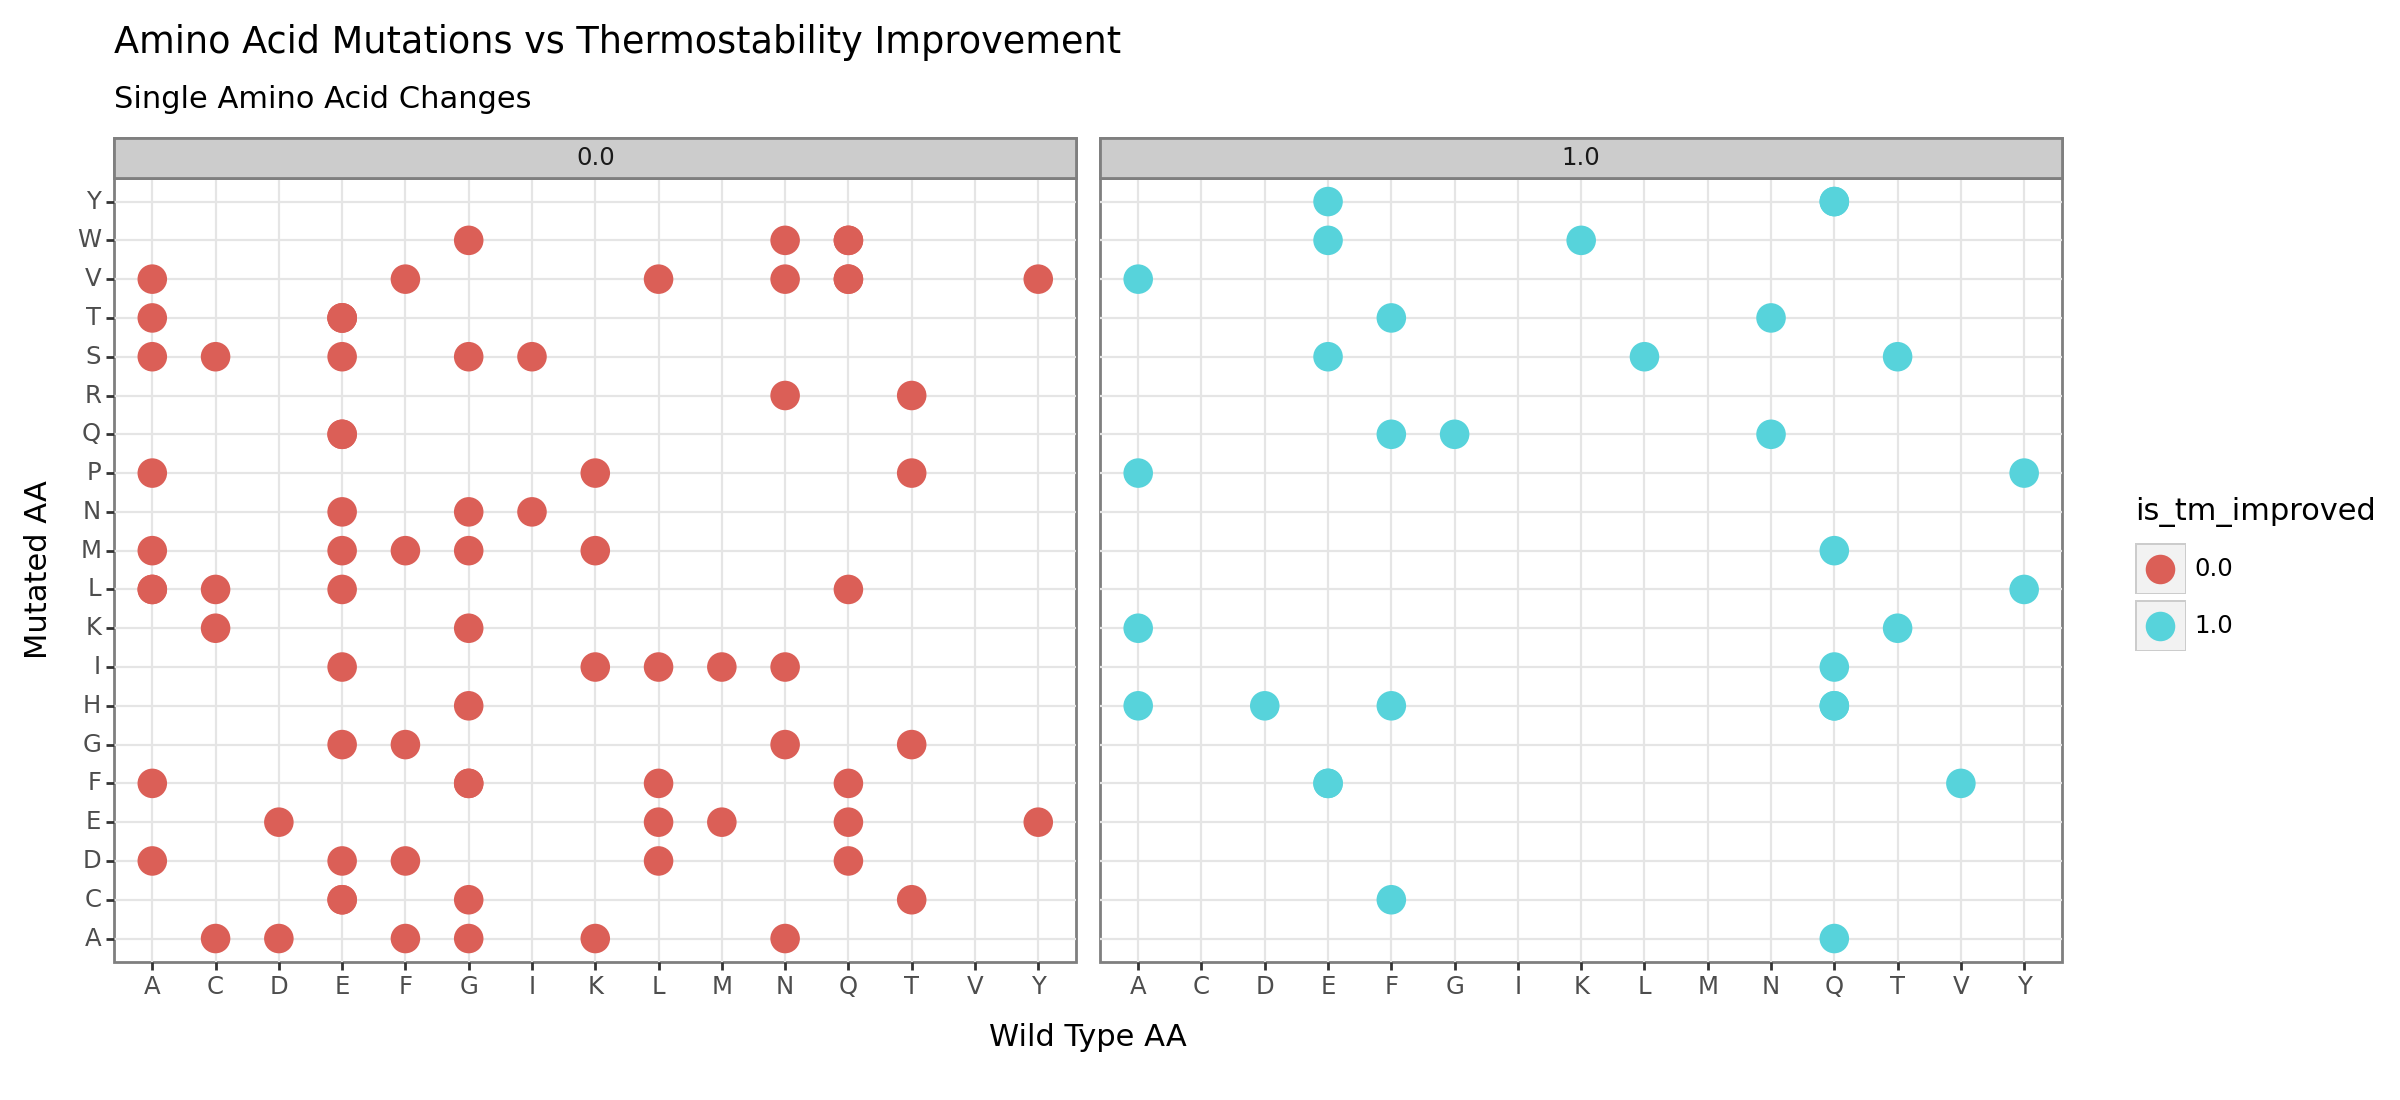

<Figure Size: (1200 x 550)>

In [47]:
# plot point mutation of each construct with TM data
p9.options.figure_size = (12, 5.5)

plt_points_aa_tm = (ggplot(data = df_mutations_stats[df_mutations_stats['mutation_type'] == "AA_change"].dropna(),
        mapping=aes(x = "wt_aa", y = "mut_aa", color = "is_tm_improved")) +
 geom_point(size = 5) +
 theme_bw()+
 ggtitle("Amino Acid Mutations vs Thermostability Improvement")+
 labs(subtitle = "Single Amino Acid Changes") +
 xlab("Wild Type AA") +
 ylab("Mutated AA") +
  facet_wrap("is_tm_improved"))
plt_points_aa_tm

Certain amino acid shifts are associated with improved TM with respect to the parental, and others are associated with decreased melting temperature. Interestingly, the parental sequence does not contain histidine (H) or arginine (R). These amino acids are positively charged and can therefore increase stickiness of an antibody (including off-target binding). In general, mutating A, D, F, or Q to H is associated with improved TM, while mutating G to H is associated with a lower mean TM. However, mutating N or T to R is associated with a decrease in melting temperature. Furthermore, any point mutations that substiute a wild-type Cysteine into another amino acid (this data tries A, K, L, and S) decreases the melting temperature of a construct. A hypothesis for this phenomenon is due to losing stabilizing disulfide bridges that Cysteines introduce into the structure of a construct.

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_density.py:166: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_density.py:171: PlotnineWarning: Groups with fewer than 2 data points have been removed.


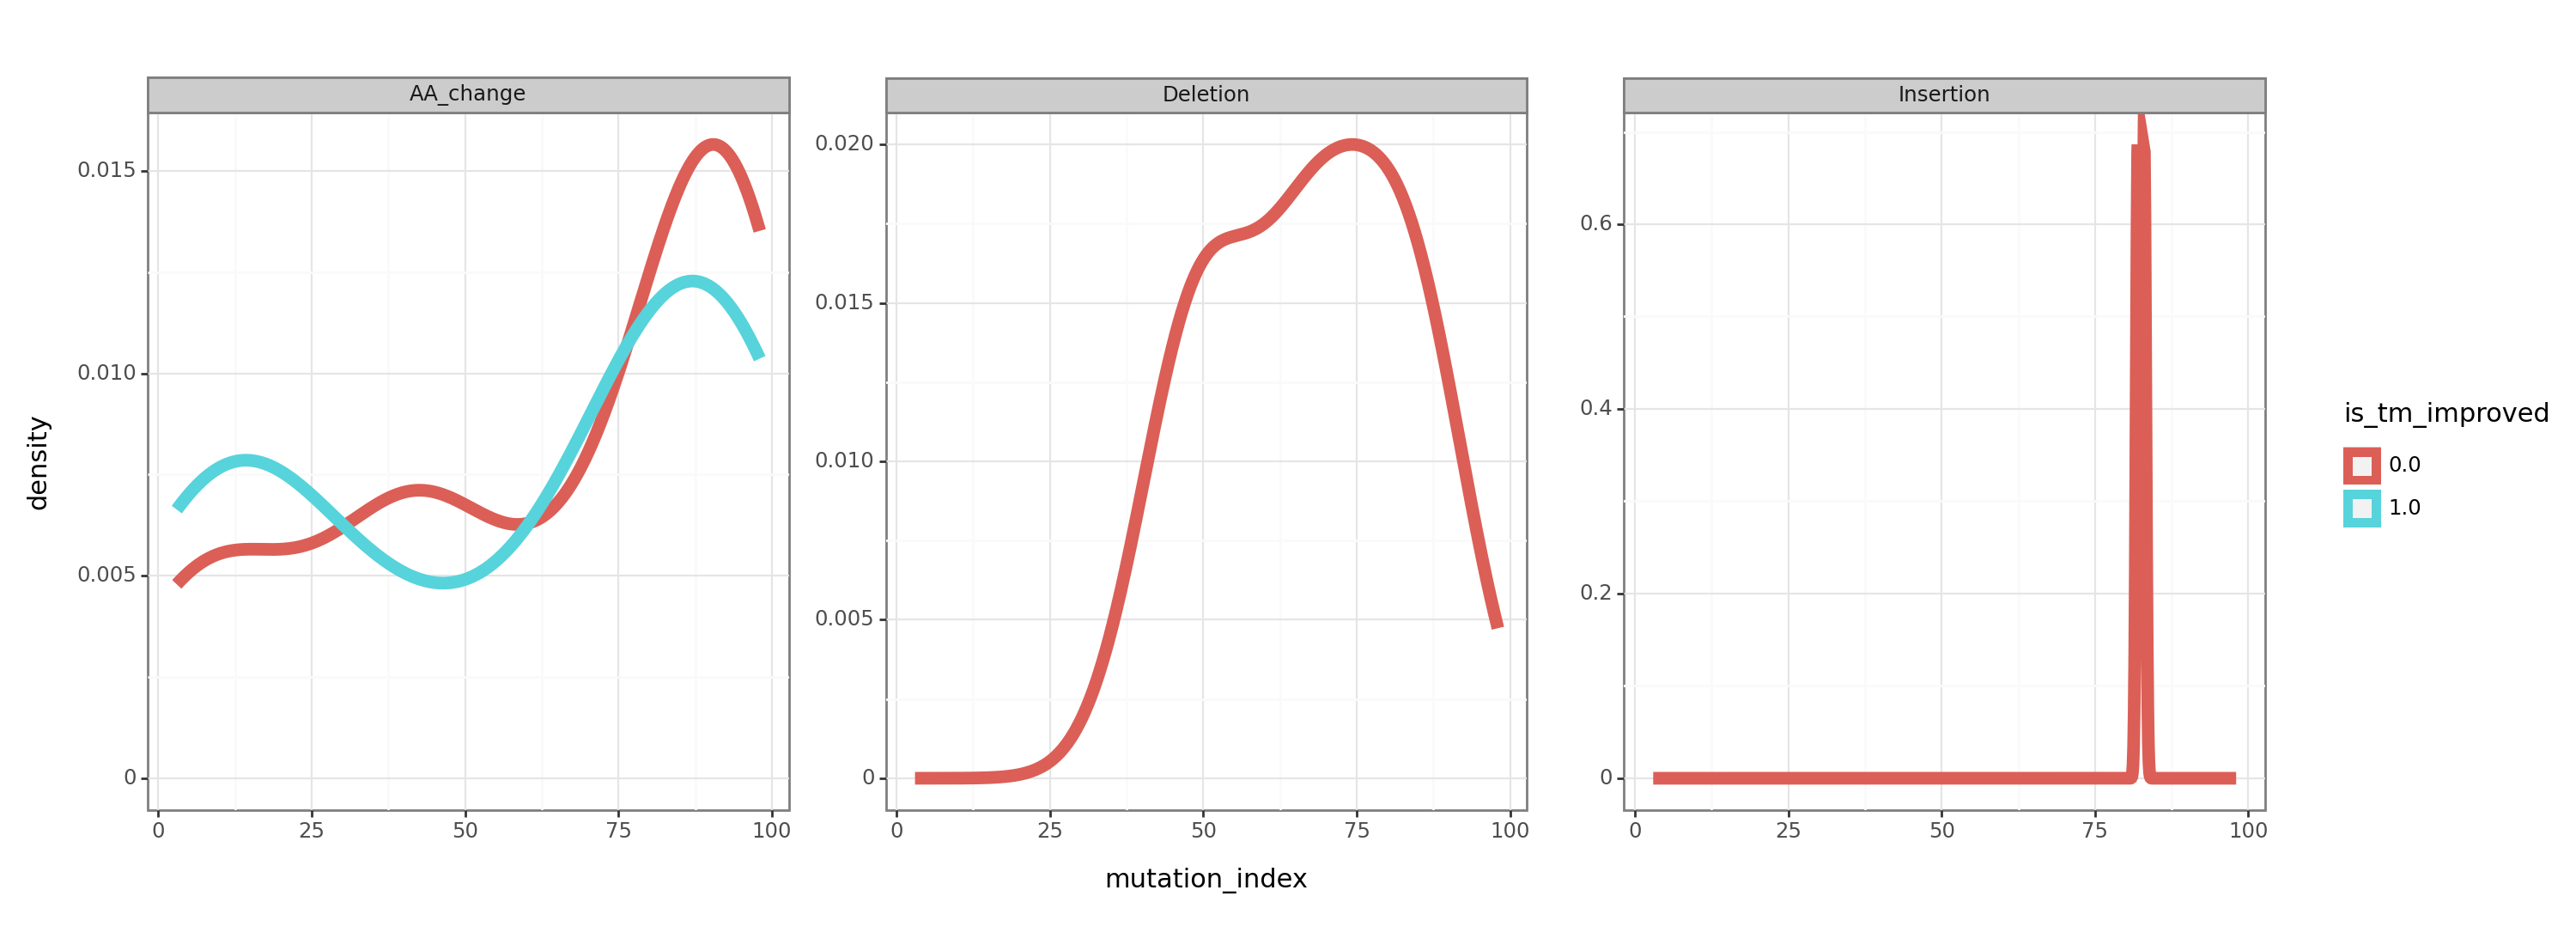

<Figure Size: (1500 x 550)>

In [48]:
# does the position of a mutation or mutation type
# impact the melting temperature?
p9.options.figure_size = (15, 5.5)

plt_density_aa_thermo = (ggplot(data = df_mutations_stats.dropna(), mapping=aes(x = "mutation_index"))+
 geom_density(aes(color = "is_tm_improved"), size = 3, alpha = 0.2) +
 theme_bw()+
 facet_wrap("mutation_type", scales = "free_y"))
plt_density_aa_thermo

Insertions and deletions do not improve the thermostability of the constructs. When focusing on amino acid shifts, mutations at the beginning of the construct, up until around amino acid position 25, slightly favor thermostability. Amino acid mutations in the center of the construct tend to decrease thermostability.

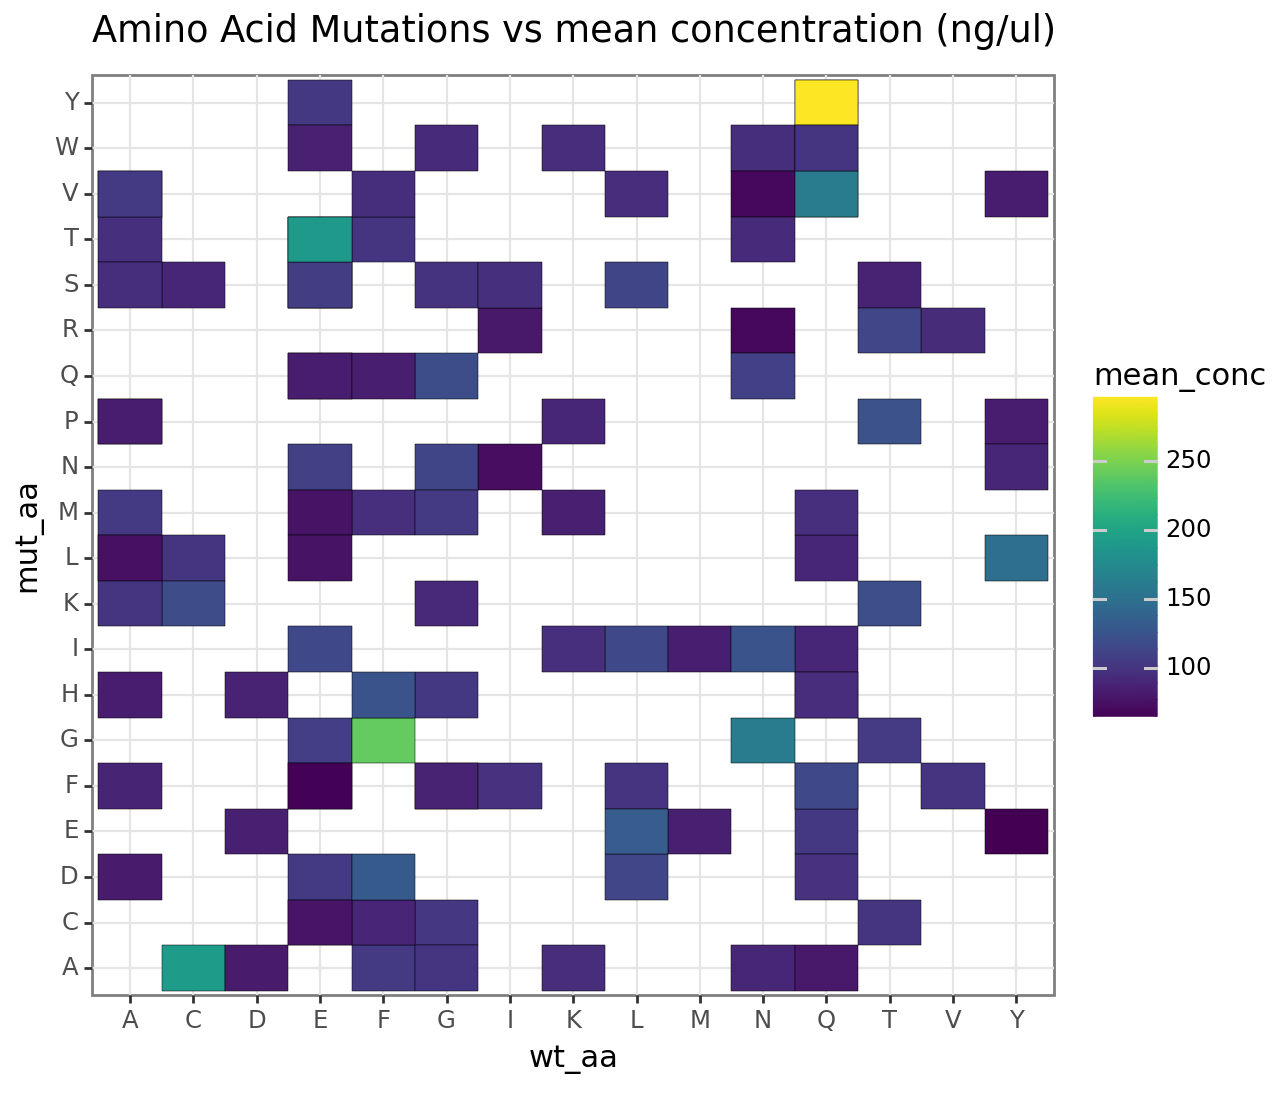

<Figure Size: (640 x 550)>

In [ ]:
# what about protein concentration?
p9.options.figure_size = (6.4, 5.5)

plt_conc_heatmap = (ggplot(data = df_mutations_stats.dropna(), mapping=aes(y = "mut_aa", x = "wt_aa", fill = "mean_conc"))+
 geom_tile(color = "black")+
 theme_bw()+
 labs(title = "Amino Acid Mutations vs mean concentration (ng/ul)"))
plt_conc_heatmap

Certain mutations increase the mean concentration of samples. Mutating Q to Y, as well as F to G, increase the mean concentration the most. Additionally, changing F to G, C to A, and E to T have some impact on increasing the mean protein concentration.

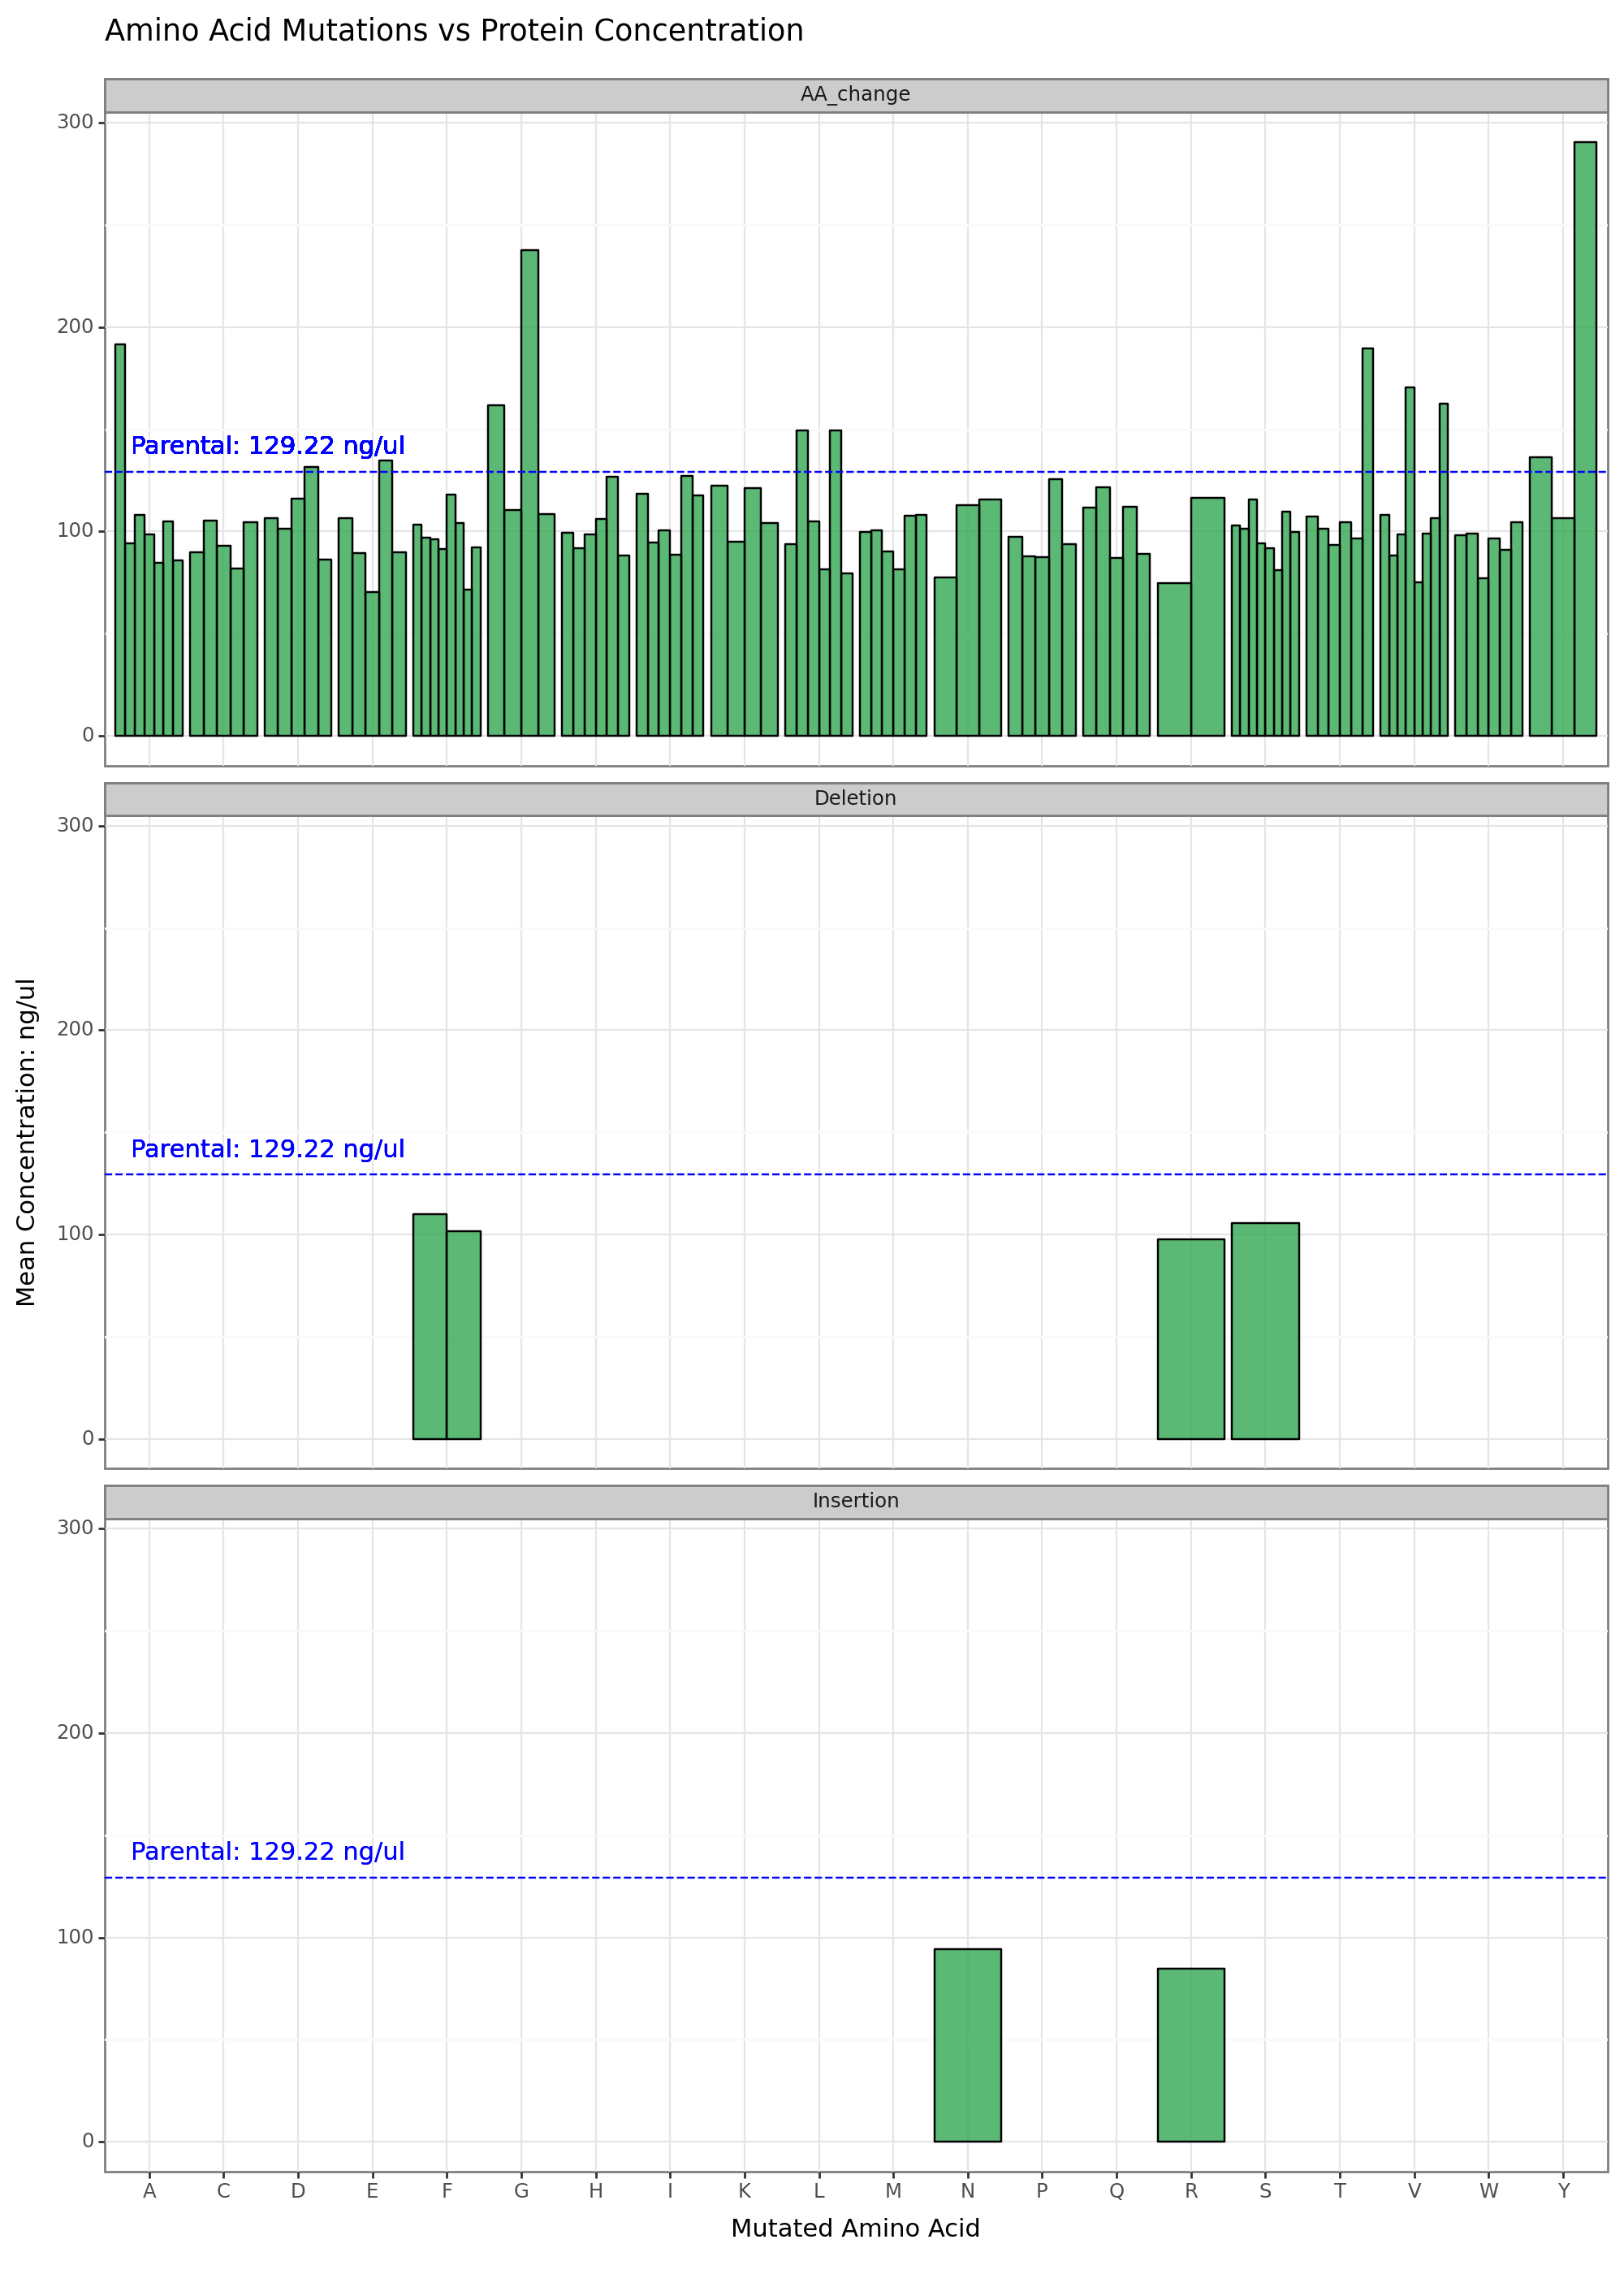

<Figure Size: (1000 x 1400)>

In [ ]:
p9.options.figure_size = (10, 14)

# get parental conc
PARENTAL_CONC = round(df_all_stats[df_all_stats["construct_name"] == PARENTAL]["mean_conc"].tolist()[0], 2)


plt_conc_bar = (ggplot(data = df_mutations_stats.dropna(),
                       mapping=aes(x = "mut_aa", y = "mean_conc", ymin="mean_conc-std_conc", ymax="mean_conc+std_conc"))+
 geom_bar(stat = "identity", position = "dodge", mapping = aes(fill = "construct_name"), show_legend=False, color = "black", alpha = 0.8)+
#  geom_errorbar(width = 0.2, position = position_dodge2(width = 0.2)) +
 facet_wrap("mutation_type", ncol = 1)+
 scale_fill_manual(values = ["#32a852"]*len(df_mutations_stats.dropna())) +
 theme_bw() +
 geom_hline(aes(yintercept = PARENTAL_CONC), color = "blue", linetype = "dashed") +
 geom_text(inherit_aes=False, mapping = aes(y = PARENTAL_CONC + 12, x = 2.6), label = "Parental: " + str(PARENTAL_CONC) + " ng/ul", color = "blue")+
 ylab("Mean Concentration: ng/ul")+
 xlab("Mutated Amino Acid") +
 labs(title = "Amino Acid Mutations vs Protein Concentration"))
plt_conc_bar

This figure describes the mutated amino acid and their mean parental concentration per construct. The deletions and insertions did not improve the mean concentration relative to the parental. Some amino acid shifts did impact the resulting protein concentration, depending on the construct. One construct which added A, two constructs which added G, two constructs which added L, one with T, two with V, and two with Y clearly improved the protein concentration above the mean parental amount. However, this plot does not provide information about the wild-type amino acid at the mutation position, nor the mutation position itself. Overall, three individual constructs which added Y, G, and A respectively had the largest impact on increasing protein concentration.

# What is the variability of replicate measurements in thermostability? Protein concentration?

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 9 rows containing non-finite values.


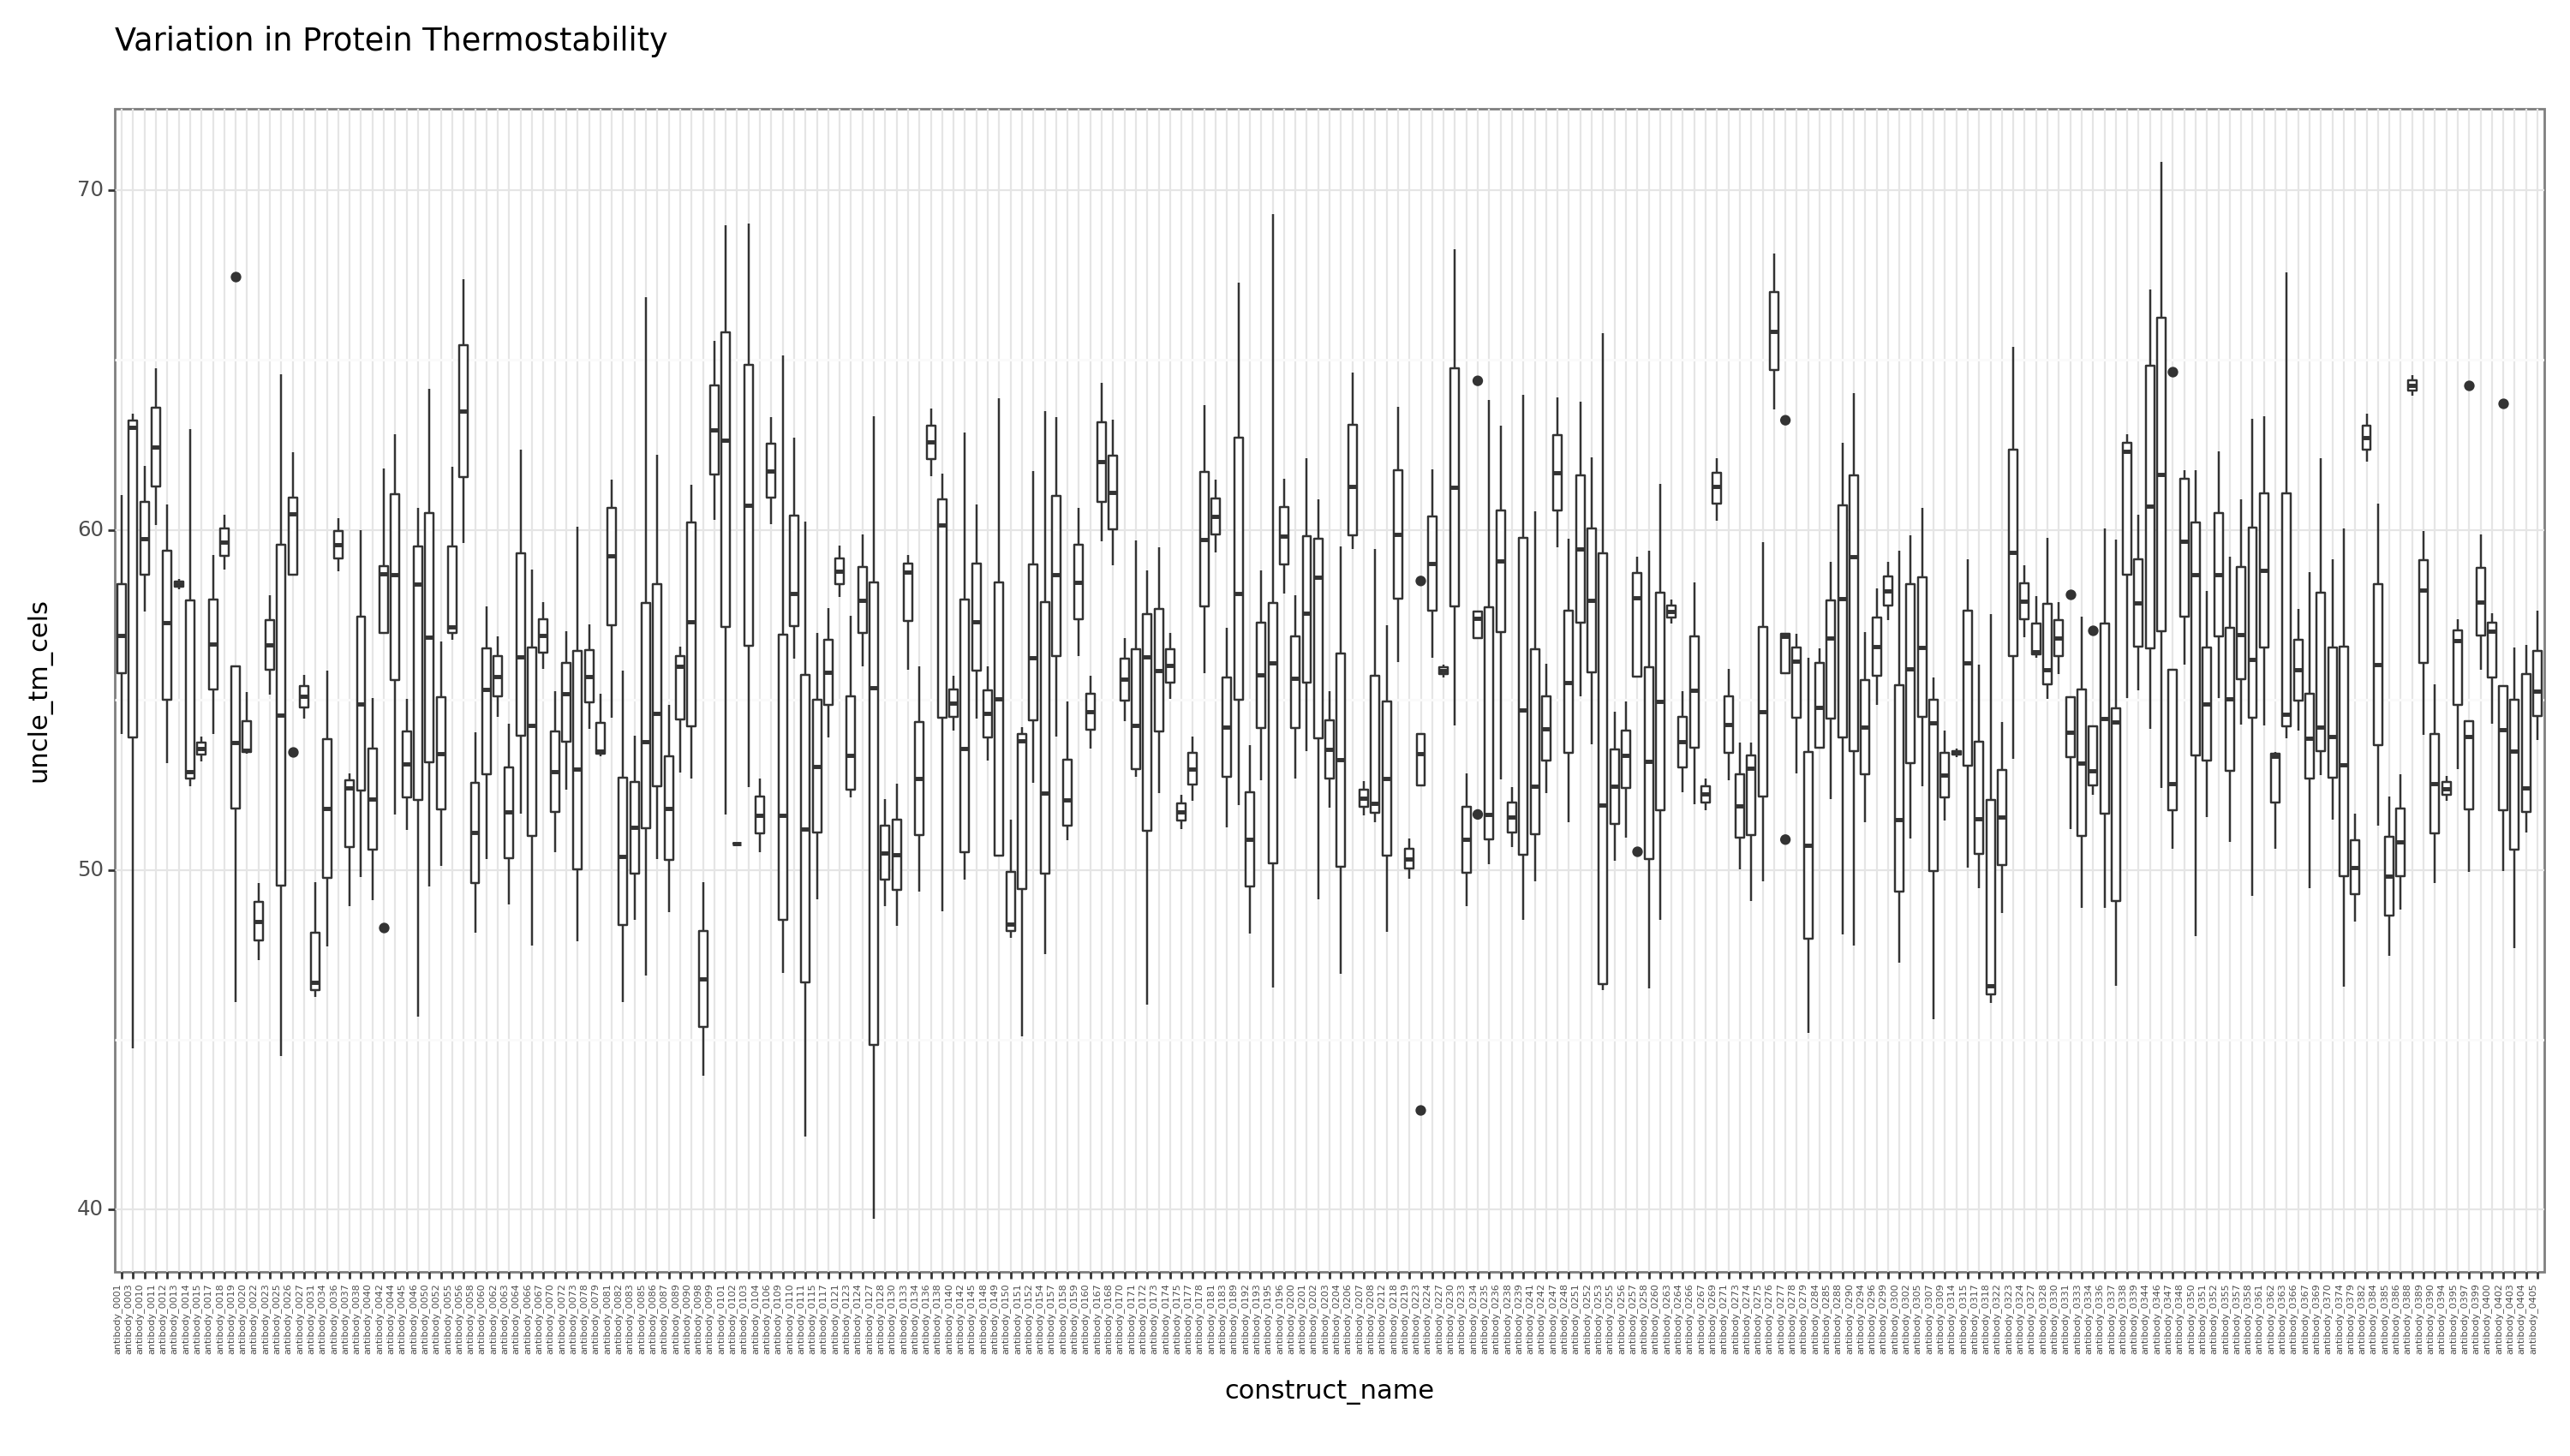

<Figure Size: (1500 x 850)>

In [ ]:
# count observations for each construct, retain those with more than one observation
thermo_grouped = df_thermo.groupby("construct_name")["uncle_tm_cels"].count()
thermo_multi_obs = thermo_grouped[thermo_grouped > 1]
df_thermo_multi = df_thermo[df_thermo['construct_name'].isin(thermo_multi_obs.index)]

p9.options.figure_size = (15, 8.5)

plt_thermo_box = (ggplot(data=df_thermo_multi, mapping=aes(x = "construct_name", y = "uncle_tm_cels")) +
       geom_boxplot() +
 theme_bw() +
 theme(axis_text_x=element_text(rotation=90, hjust=1, size = 4)) +
                  labs(title = "Variation in Protein Thermostability"))
plt_thermo_box

This data suggests that there is a large amount of variation per construct in melting point measurements. Many of these constructs can range around 20 degrees C; and a few include outlier values. By contrast, some constructs do not vary much. Additionally, this plot does not show the number of experimental samples taken per construct, which may be necessary in order to provide clarity on the potential causes of such variation in some constructs.

In [ ]:
df_thermo_stats_multi = df_thermo_stats[df_thermo_stats["count"] > 1]
df_thermo_stats_multi

,mean,std,min,max,median,count
construct_name,,,,,,
antibody_0001,57.134444,1.991618,53.99,61.03,56.905,18
antibody_0003,57.063333,10.665535,44.75,63.42,63.020,3
antibody_0010,59.745000,3.033488,57.60,61.89,59.745,2
antibody_0011,62.445000,3.259762,60.14,64.75,62.445,2
antibody_0012,57.107500,3.395403,53.13,60.74,57.280,4
...,...,...,...,...,...,...
antibody_0400,56.290000,1.742154,54.30,57.54,57.030,3
antibody_0402,54.996000,5.312446,49.96,63.72,54.120,5
antibody_0403,52.576667,4.490215,47.70,56.54,53.490,3


In [ ]:
# count observations for each construct, retain those with more than one observation
quant_grouped = df_quant.groupby("construct_name")["conc_ng_ul"].count()
quant_multi_obs = quant_grouped[quant_grouped > 1]
df_quant_multi = df_quant[df_quant['construct_name'].isin(quant_multi_obs.index)]
df_quant_multi

,construct_name,protein_aliquot_name,conc_ng_ul,experiment_date
0,antibody_0001,antibody_0001-G,100.34,2023-11-15
1,antibody_0001,antibody_0001-B,123.47,2023-11-06
2,antibody_0001,antibody_0001-E,97.10,2023-11-13
3,antibody_0001,antibody_0001-D,106.45,2023-11-09
4,antibody_0001,antibody_0001-J,113.61,2023-11-17
...,...,...,...,...
688,antibody_0109,antibody_0109-D,108.19,2023-11-28
690,antibody_0300,antibody_0300-B,124.65,2023-11-27
691,antibody_0255,antibody_0255-B,93.71,2023-11-27
692,antibody_0206,antibody_0206-A,122.42,2023-11-06


/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 14 rows containing non-finite values.


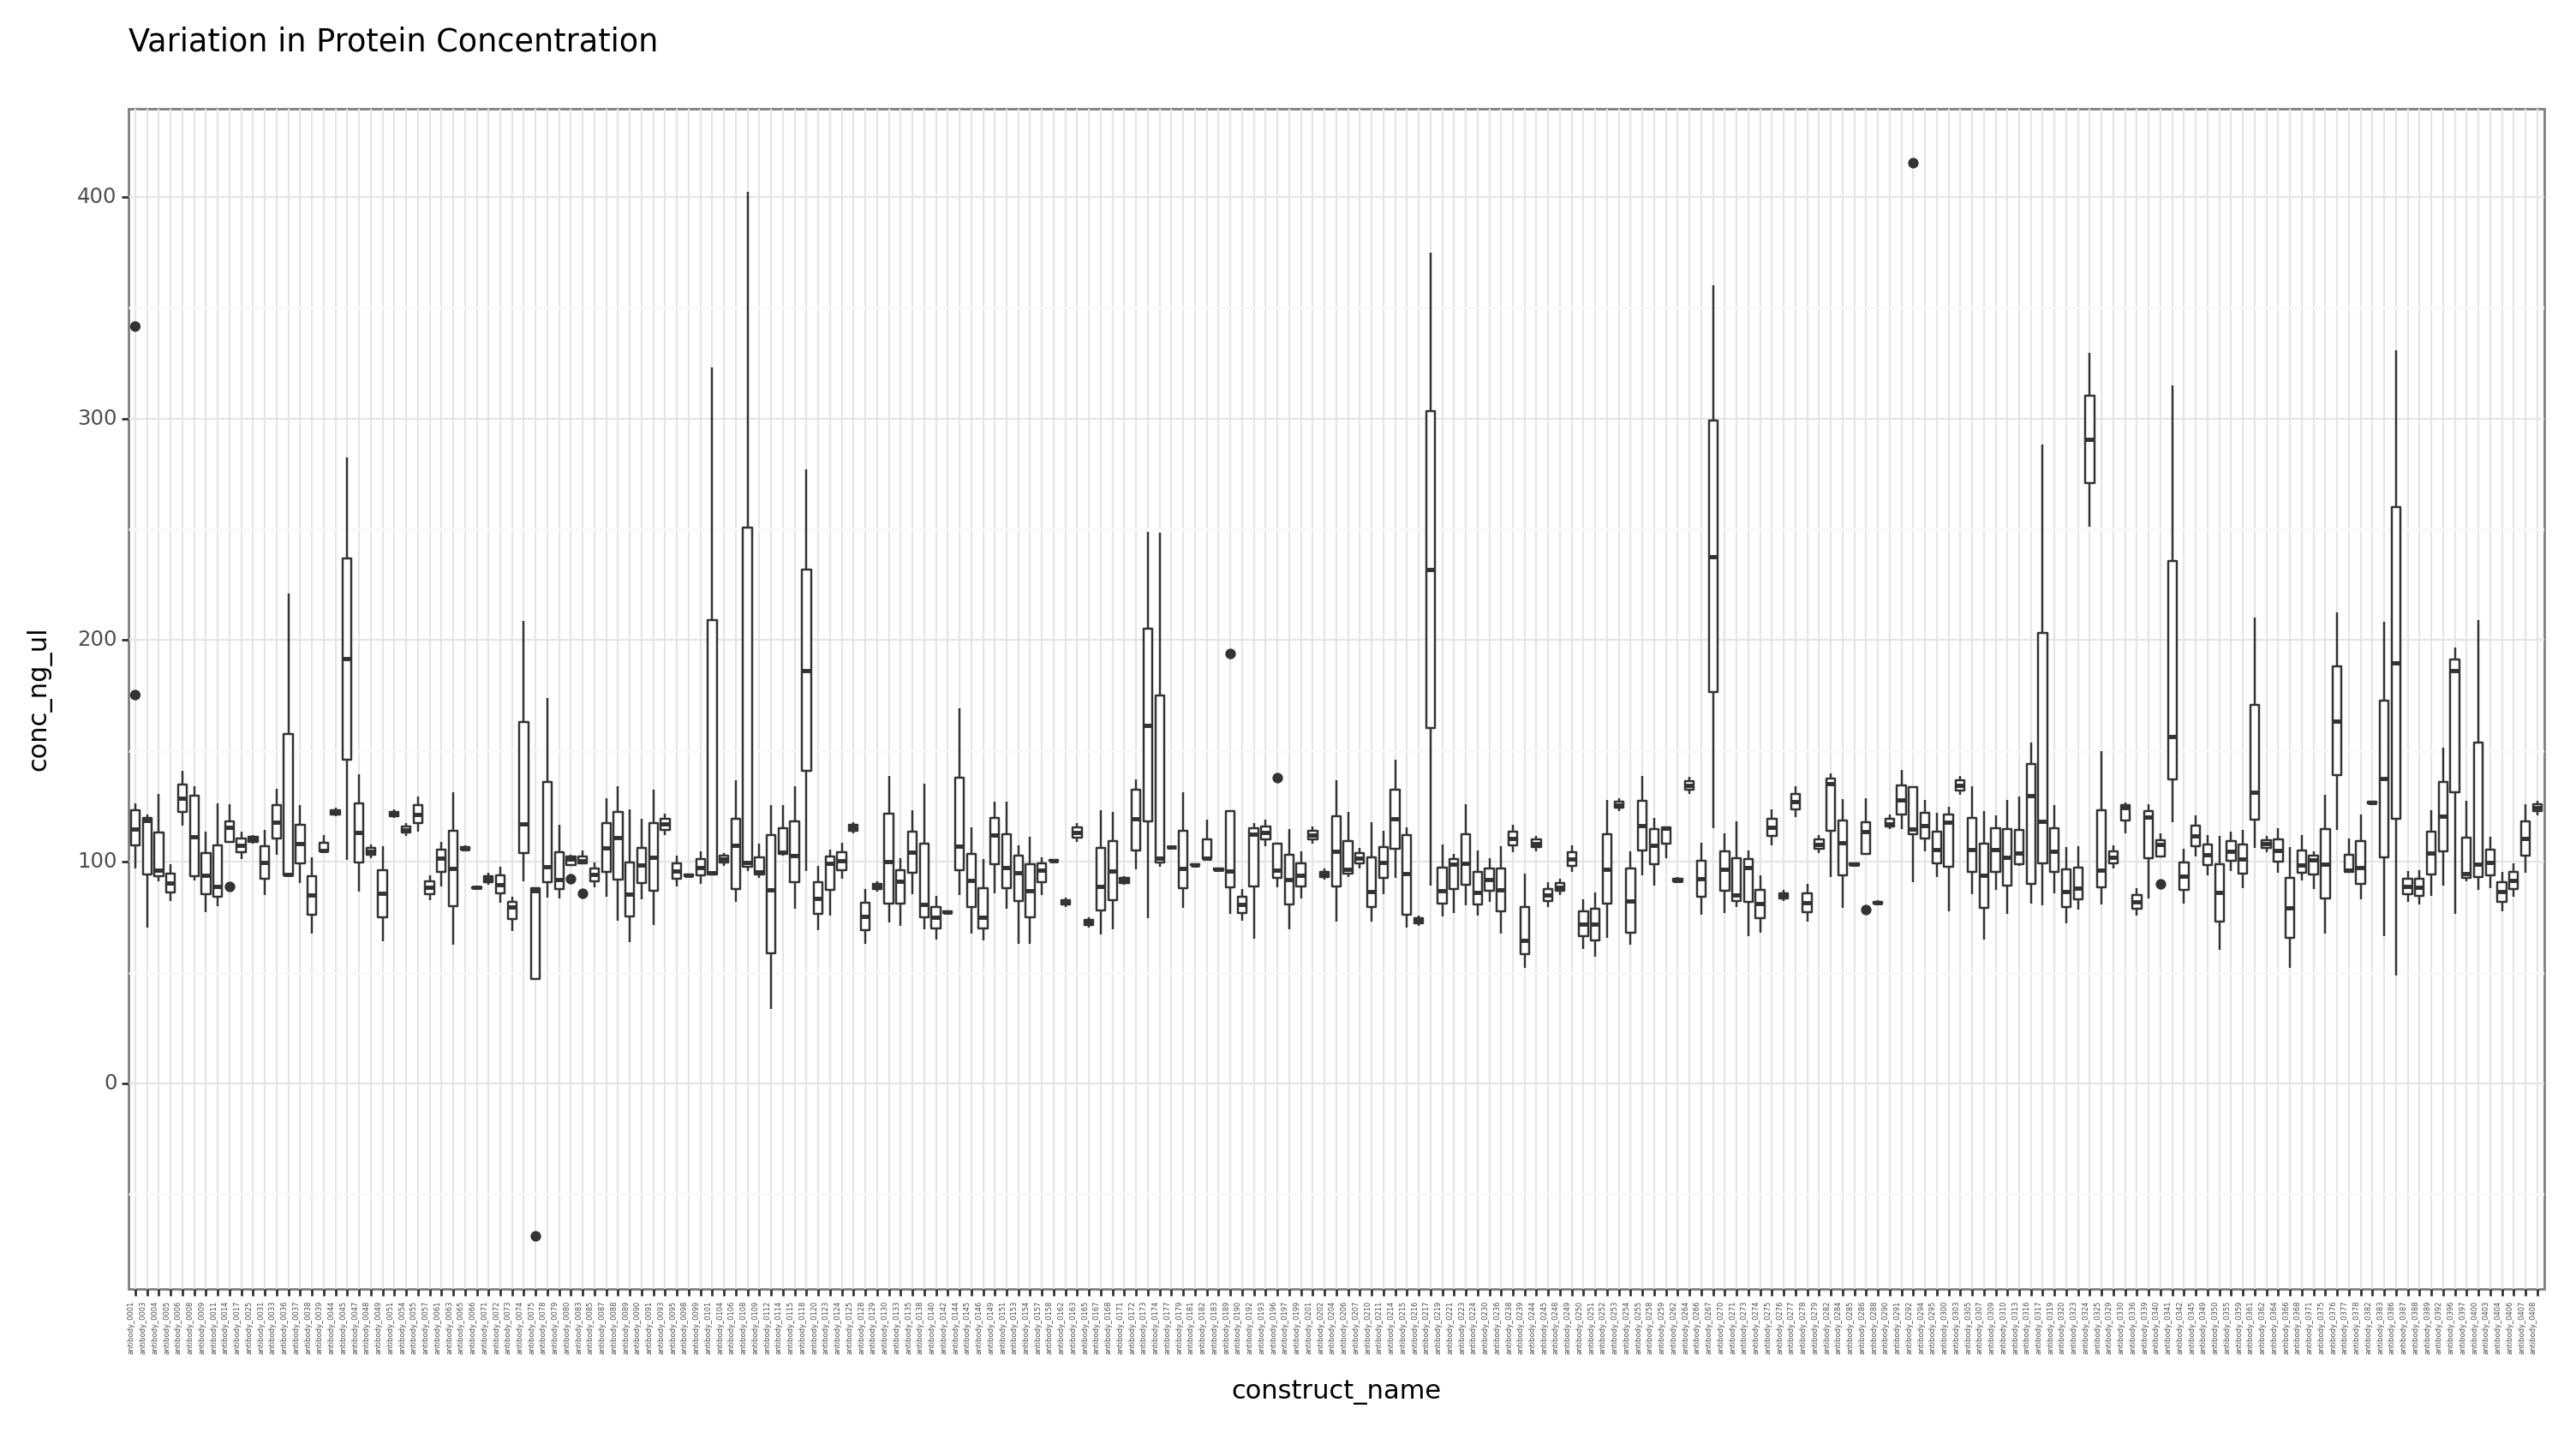

<Figure Size: (1500 x 850)>

In [ ]:
p9.options.figure_size = (15, 8.5)

plt_quant_box = (ggplot(data=df_quant_multi, mapping=aes(x = "construct_name", y = "conc_ng_ul")) +
       geom_boxplot() +
 theme_bw() +
 theme(axis_text_x=element_text(rotation=90, hjust=1, size = 3)) +
                 labs(title = "Variation in Protein Concentration"))

plt_quant_box

Some individual constructs contain outliers and vary quite a bit, while other replicate measurement values are relatively consistent. The means of constructs with the most varation in concentration tend to trend higher compared to the means of constructs with less variation in concentration measurements.

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 164 rows containing non-finite values.


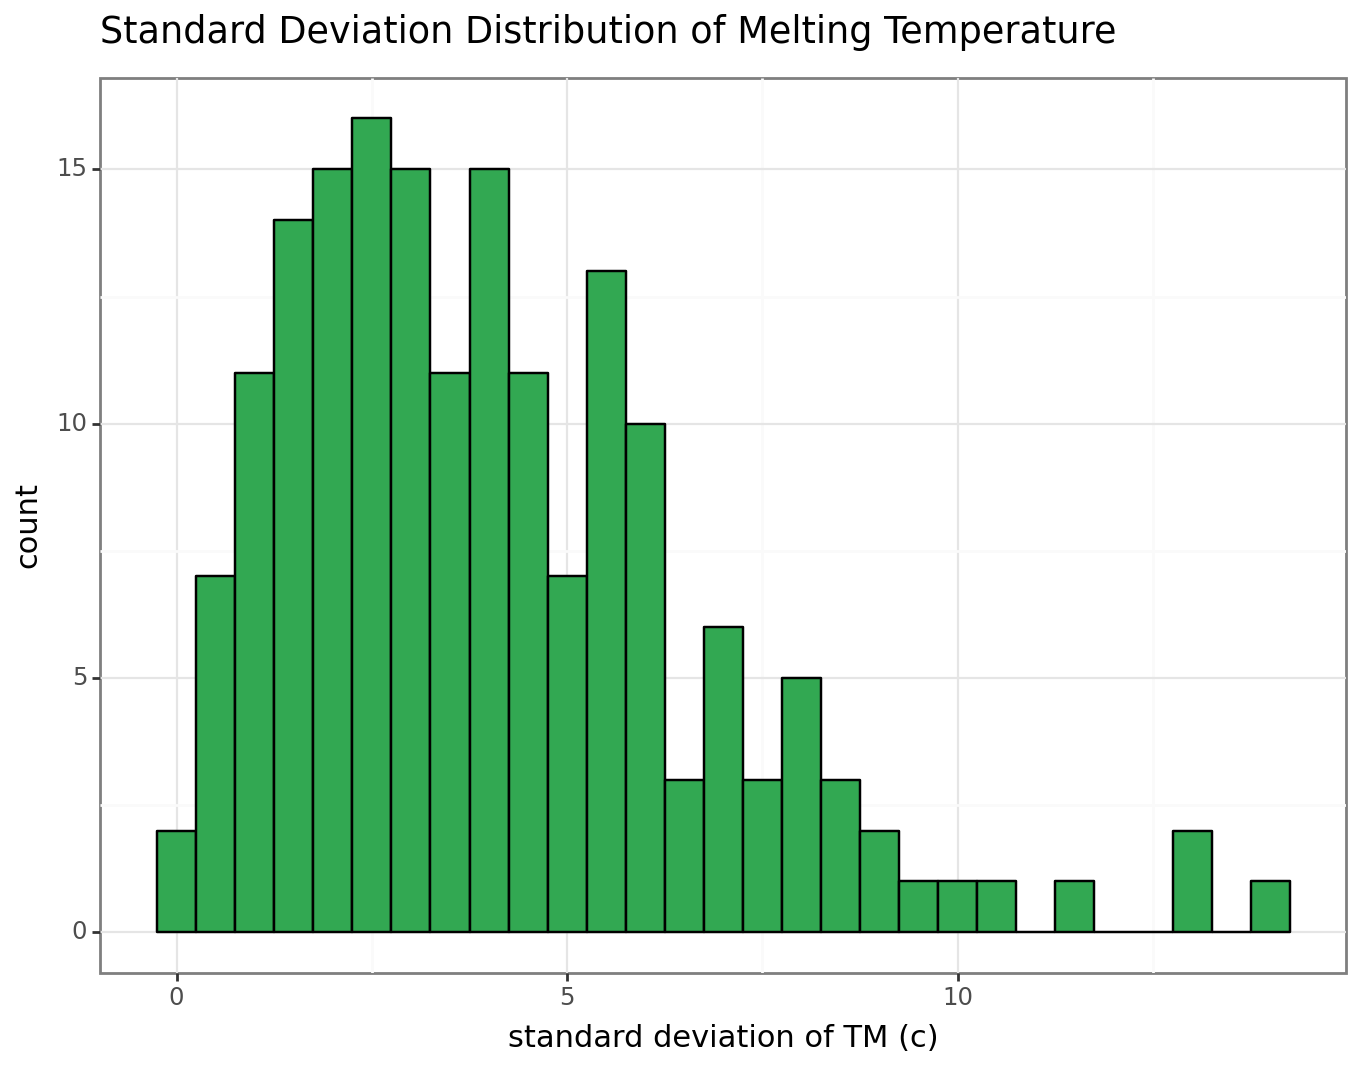

<Figure Size: (680 x 540)>

In [ ]:
p9.options.figure_size = (6.8, 5.4)

plt_std_tm = (ggplot(data = df_stats, mapping=aes(x = "std_tm")) +
 geom_histogram(binwidth=0.5, color = "black", fill = "#32a852") +
 theme_bw()+
 labs(title = "Standard Deviation Distribution of Melting Temperature",
      x = "standard deviation of TM (c)"))
plt_std_tm

The majority of standard deviations of melting points are below 10c, with a few standard deviations trending higher.

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 135 rows containing non-finite values.


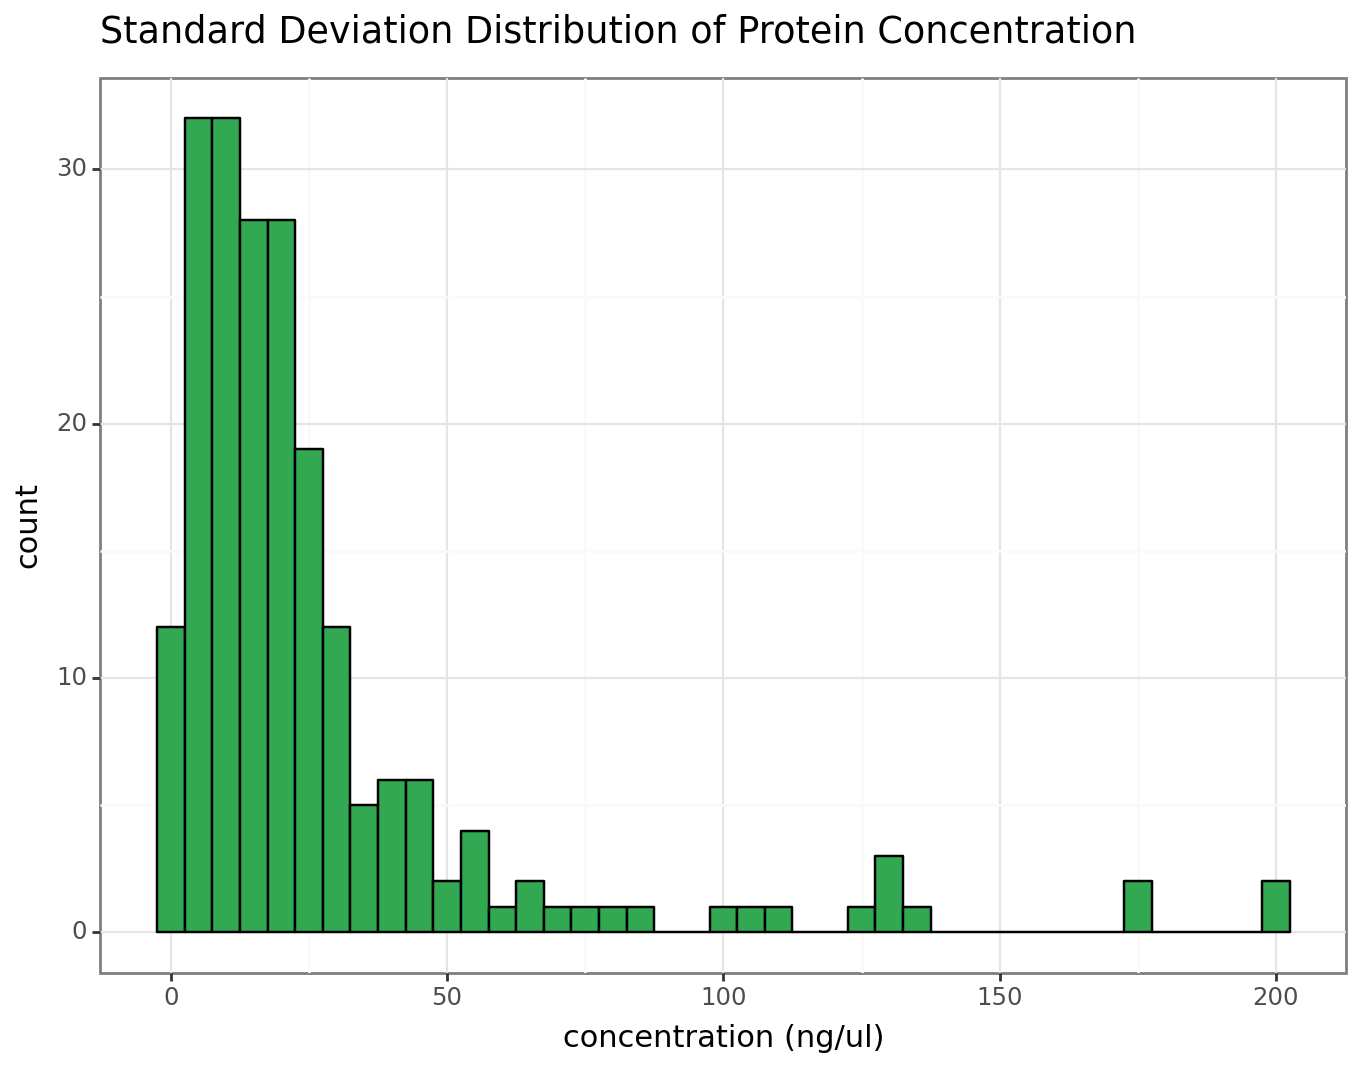

<Figure Size: (680 x 540)>

In [ ]:
plt_std_conc = (ggplot(data = df_stats, mapping=aes(x = "std_conc")) +
 geom_histogram(binwidth=5, color = "black", fill = "#32a852") +
 theme_bw()+
 labs(title = "Standard Deviation Distribution of Protein Concentration",
      x = "concentration (ng/ul)"))
plt_std_conc

The majority of protein concentration standard deviations are below 50 ng/ul, but a few constructs' standard deviations increase up to 200 ng/ul. Perhaps the experimental conditions or mutations of these samples with a standard deviation larger than 50 ng/ul should be investigated.